# **Clustering of Chicago low-level regions according to historical taxi trips**

In order to do the clustering, we need to implement the following steps:

1. create a mapping from GPS coordinates into region IDs
2. construct a matrix of new-flow per region IDs and per unit of time. An entry in the matrix, at region ID i and given hour j, represents the total number of taxi pickups.
3. construct a matrix of end-flow per region IDs and per unit of time. An entry in the matrix, at region ID i and given hour j, represents the total number of taxi dropoffs.
4. Build a weight matrix representing node weights. It's the sum element wise of the previous two matrices.
5. compute the Spearman's rank correlation. It's the correlation of new-flows per time for two distinct region IDs.
6. implement the graph clustering algorithm to cluster the low-level regions into m high-level regions.
7. build the elbow graph of edge cut in function of m

In order to do the clustering, we will use 3 months of taxi trips data for consistency. 

**Setting up the notebook environment**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#Libraries needed in this notebook
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
import math

from collections import Counter
import statistics 
from statistics import mode 

In [ ]:
!pip install ipython-autotime

%load_ext autotime

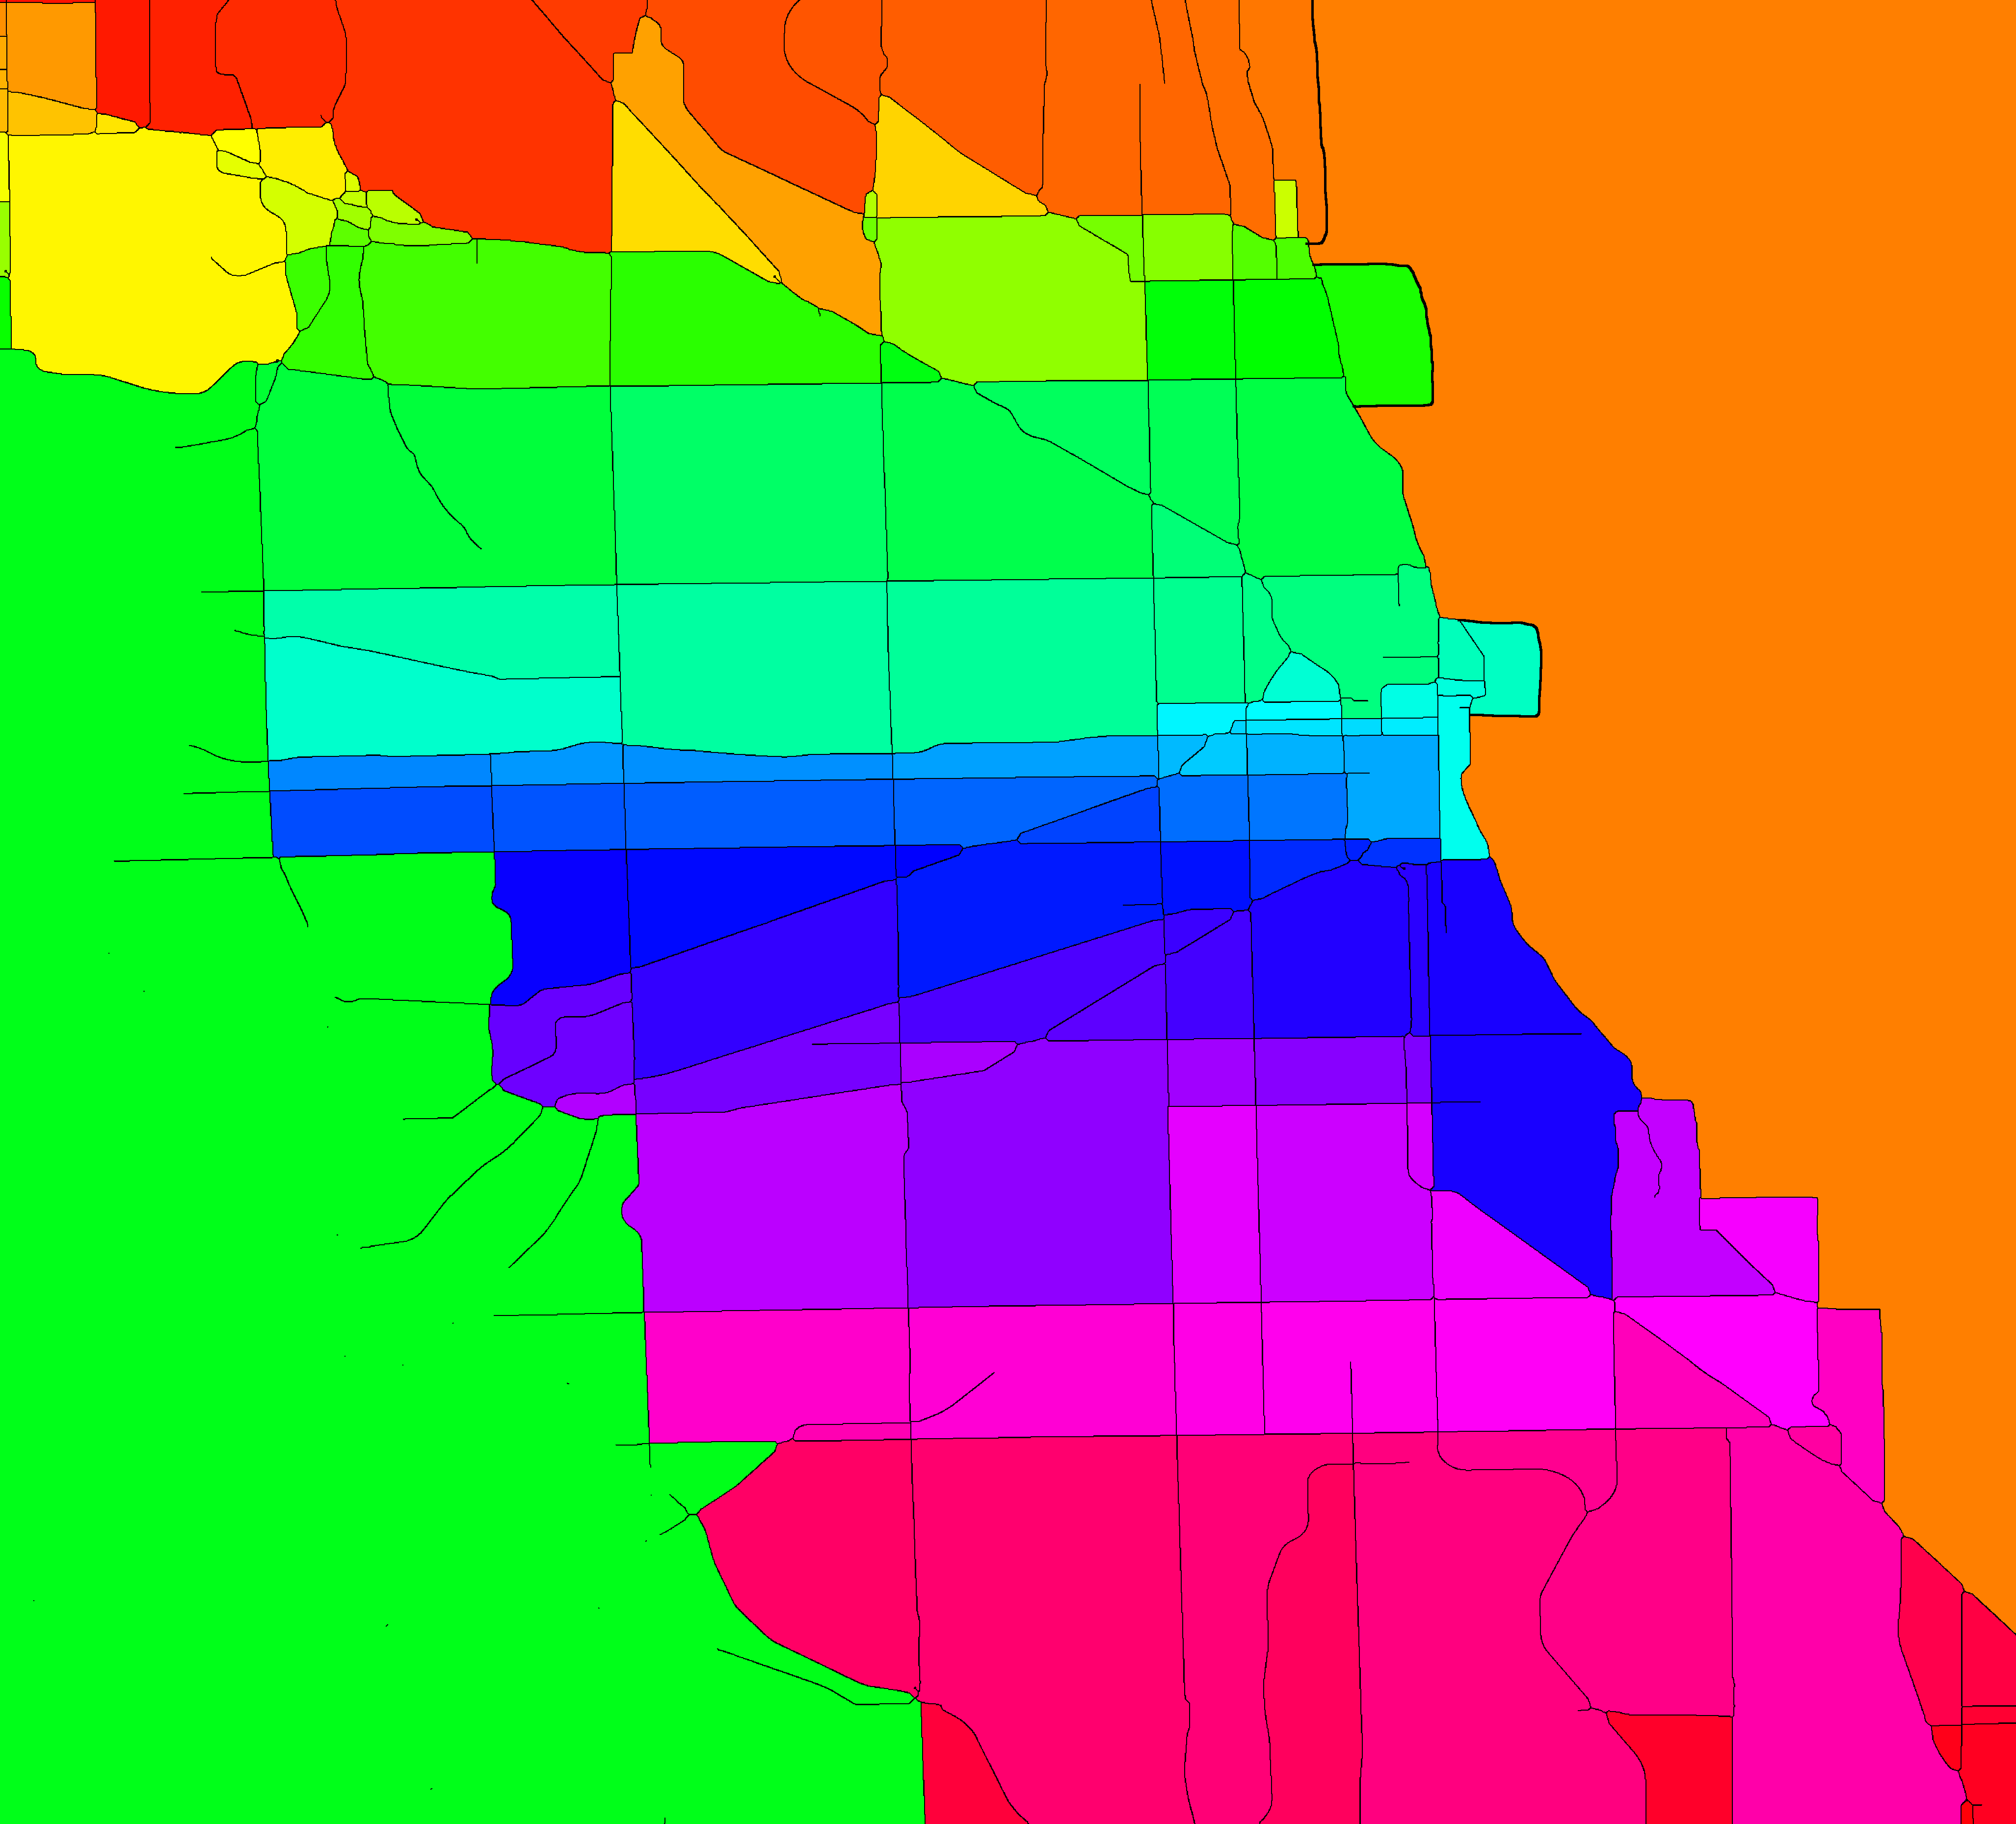

time: 1.62 s


In [ ]:
img = cv2.imread('/content/chicago_road_network_thinned_inverted_2 tomodify.png', 0)
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(img)

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    #from google.colab.patches import cv2_imshow
    cv2_imshow(labeled_img)
    cv2.imwrite('chicago_labeled.png',labeled_img) 

imshow_components(labels_im)

In [ ]:
def writeTextsOnImage(imagePath, textCoordinatesArray, textColor, saveImage = False, labeledImagePath = None):
  image = cv2.imread(imagePath) 
  font = cv2.FONT_HERSHEY_SIMPLEX 
  color = textColor
  fontScale = 1
  thickness = 2
  for textElement in textCoordinatesArray:
    textStr = textElement[0]
    coordinatesTuple = textElement[1]
    image = cv2.putText(image, textStr, coordinatesTuple, font,  
                   fontScale, color, thickness, cv2.LINE_AA) 
  
  if saveImage and labeledImagePath:
    cv2.imwrite(labeledImagePath,image)
  
  cv2_imshow( image)

def buildTextCoordinatesArray(centroidsArray):
  textCoordinatesArray = []
  n = len(centroidsArray)
  i = 1
  while i < n:
    x = np.int64(centroidsArray[i][0])
    y = np.int64(centroidsArray[i][1])
    CoordTuple = tuple((x, y))
    textStr = str(i)
    textCoordinatesArray.append([textStr, CoordTuple])
    i = i + 1
  return textCoordinatesArray

time: 17.8 ms


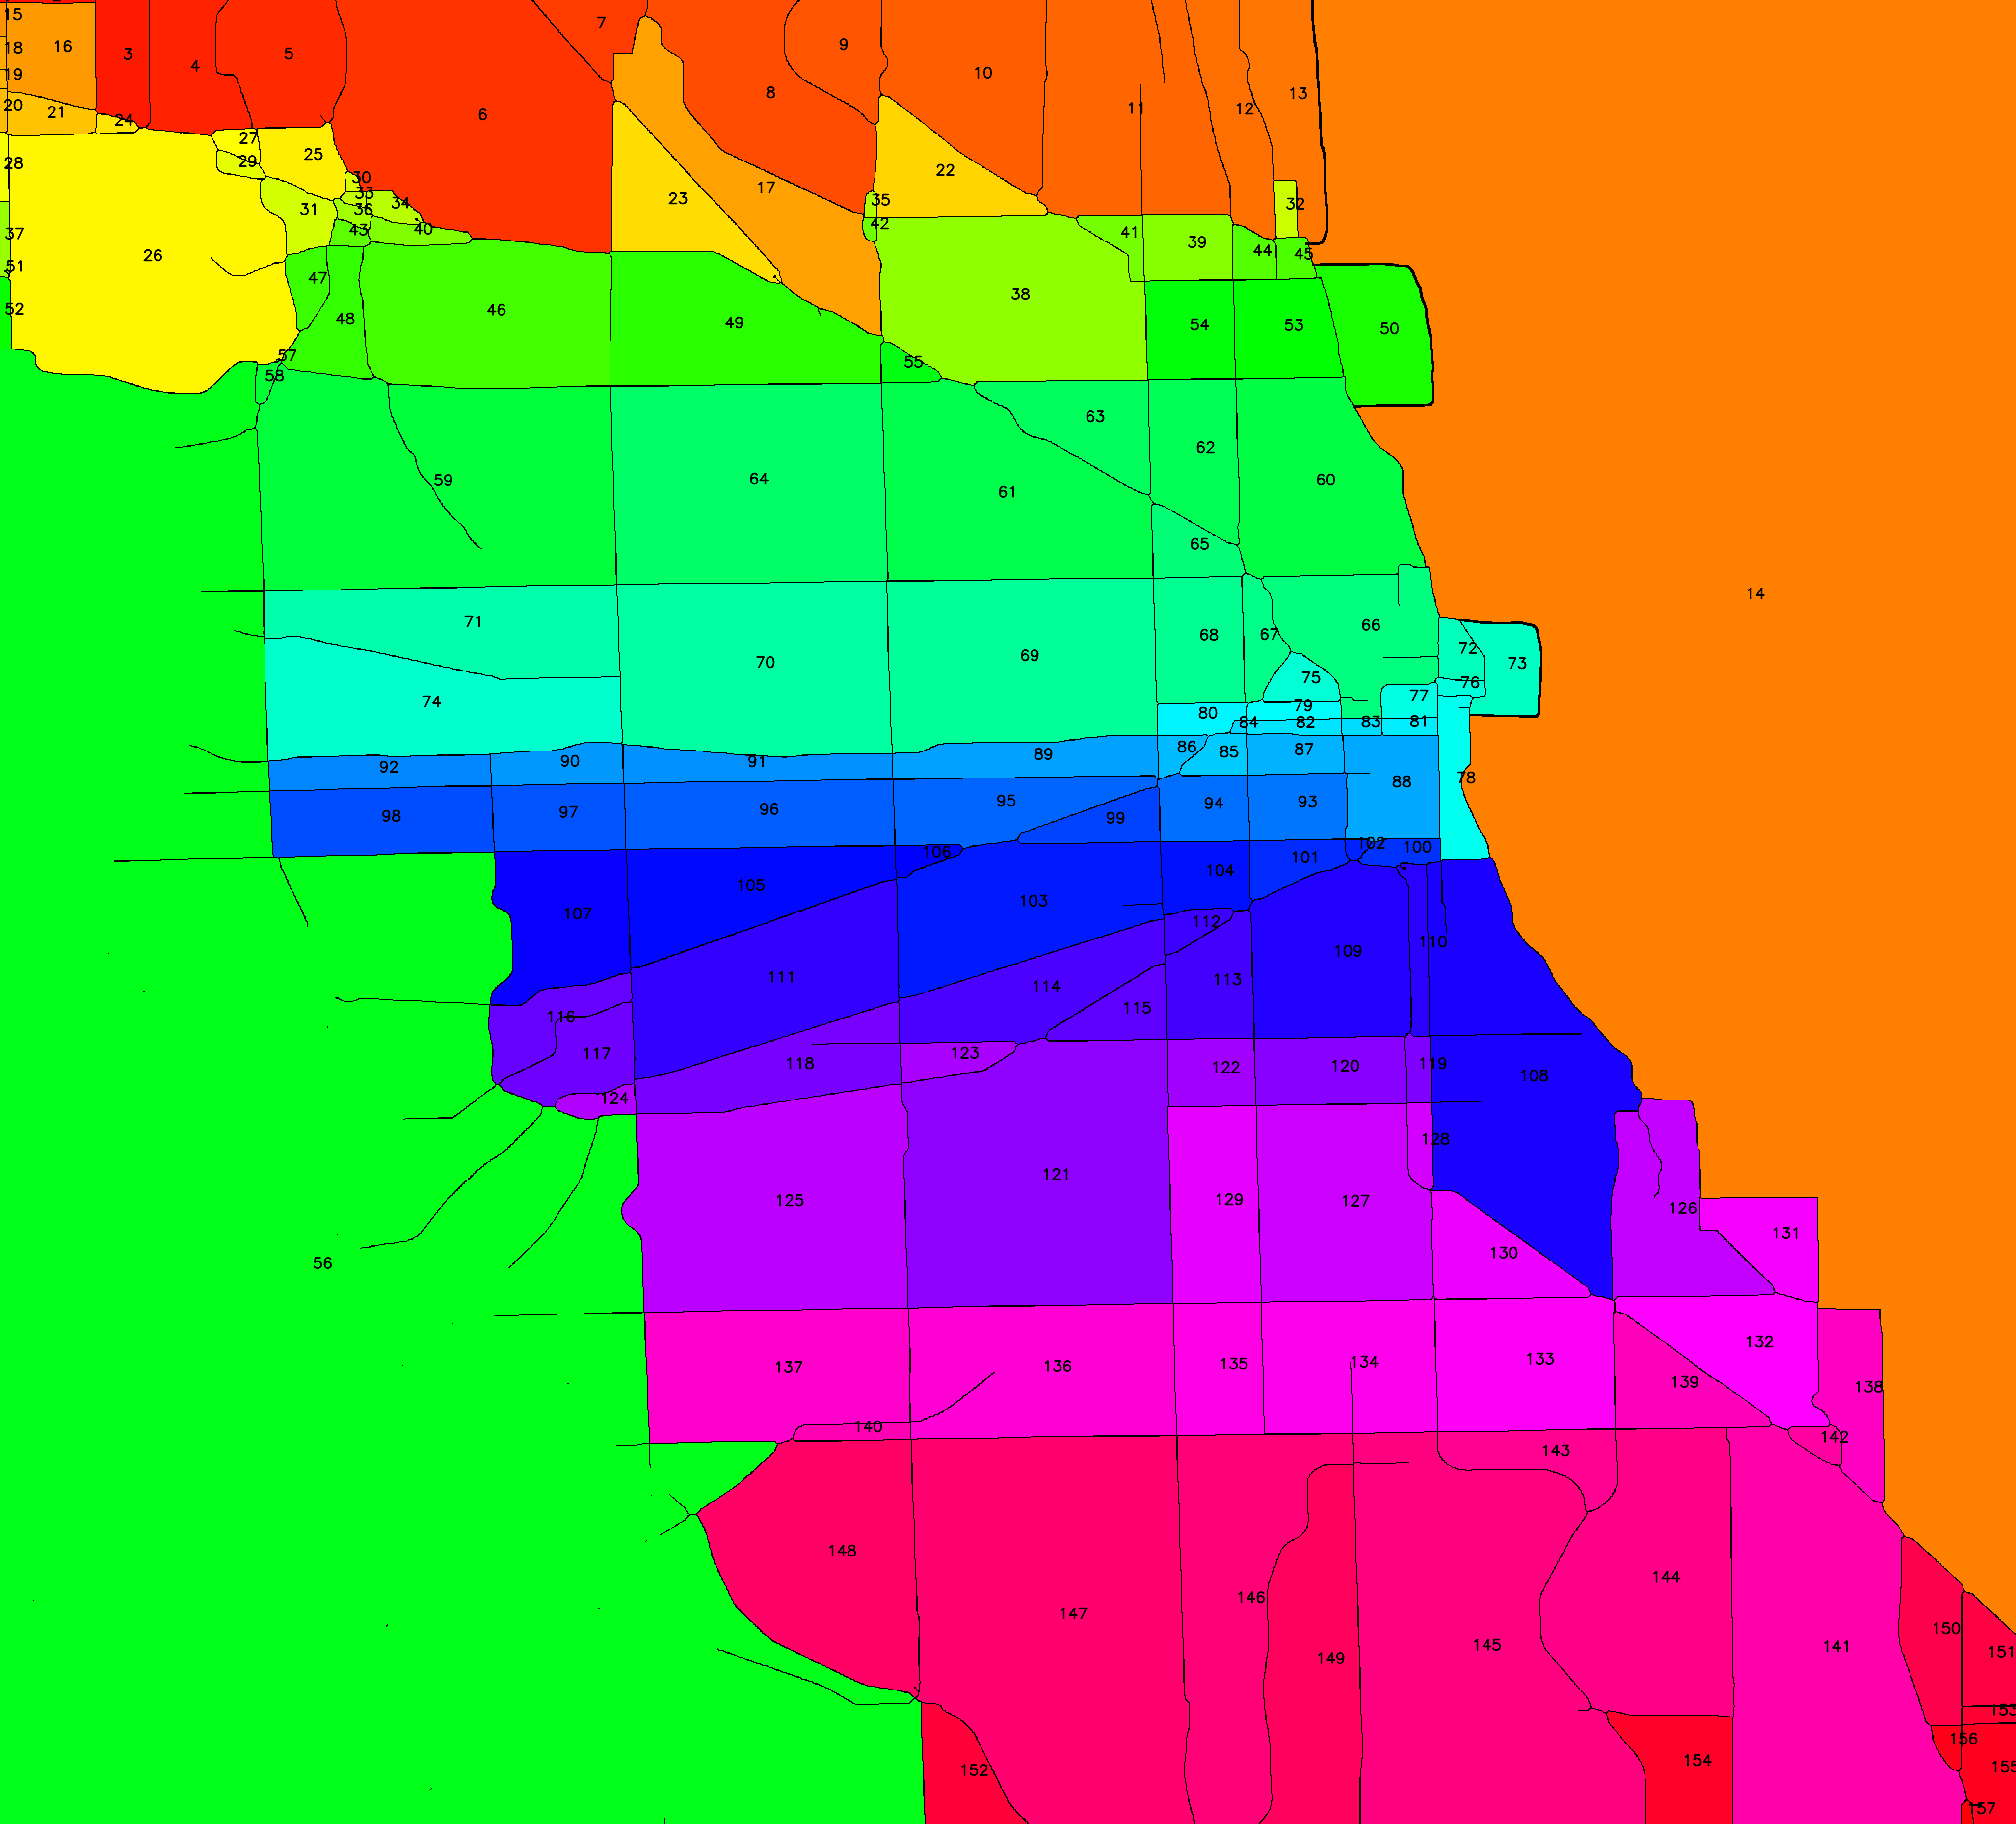

time: 935 ms


In [ ]:
image_path = r"/content/chicago_labeled.png"
text_coord_array = buildTextCoordinatesArray(centroids)
color = (1, 1, 1)
writeTextsOnImage(image_path, text_coord_array, color, False, '')

In [ ]:
from numpy import loadtxt
# load array
graph_matrix = loadtxt('/content/gdrive/My Drive/urban-computing-project/graph_matrix_with3newregions.csv', delimiter=',')

time: 749 ms


In [ ]:
def returnConnectedRegionIDsFor(regionID, graphMatrix):
  n = graphMatrix.shape[0]
  regionID = regionID - 1
  if regionID < 0 or regionID >= n:
    return []
  connectedRegionIDs = []
  i = 0
  while i < n:
    connected = graphMatrix[regionID][i]
    if connected == 1 and regionID != i:
      connectedRegionIDs.append(i+1)
    i = i + 1
  return connectedRegionIDs

time: 3.79 ms


## **Mapping of GPS coordinates to pixels**

In [ ]:
def showGPSCoordinatesOnMap(imagePath, pixelCoordinatesArray, markColor = [255,0,0]):
  baseimage = cv2.imread(imagePath)
  n = baseimage.shape[0]
  m = baseimage.shape[1]
  notMappable = []
  for pixelCoordinates in pixelCoordinatesArray:
    if pixelCoordinates[0] < n and pixelCoordinates[1] < m:
      baseimage[pixelCoordinates[0], pixelCoordinates[1]] = markColor
      baseimage[pixelCoordinates[0] - 4, pixelCoordinates[1]] = markColor
      baseimage[pixelCoordinates[0] + 4, pixelCoordinates[1]] = markColor
      baseimage[pixelCoordinates[0], pixelCoordinates[1] - 4] = markColor
      baseimage[pixelCoordinates[0], pixelCoordinates[1] + 4] = markColor
    else:
      notMappable.append( [pixelCoordinates[0],pixelCoordinates[1]] )
  
  from google.colab.patches import cv2_imshow
  cv2_imshow(baseimage)
  
  if len(notMappable) > 0 :
    print("Error: some GPS coordinates are outside the map ", notMappable)

time: 8.52 ms


I manually selected 3 reference positions, far away from each other, on the vertical and horizontal axis for better precision. They will be used for scaling from latitude/longitude to pixels. For each reference point, the first array shows the GPS coordinates (lat, long) and the second array the position in pixel on the image 'Chicago_labeled.png' .

In [ ]:
#Reference points specific to 'chicago_labeled.png'
#those reference positions were obtained manually
reference1 = [[41.8668444501613, -87.66638134255284], [1579, 2542]]
reference2 = [[41.86498800990286, -87.80418527893], [1596, 1271]]
reference3 = [[41.72122396063887, -87.66264594740444], [2922, 2577]]

#Constant needed for computing [x,y] in pixels faster
deltalong13 = reference1[0][0] - reference3[0][0]
deltapixel13 = reference1[1][0] - reference3[1][0]
ratiopixelX = deltapixel13 / deltalong13

deltalat12 = reference1[0][1] - reference2[0][1]
deltapixel12 = reference1[1][1] - reference2[1][1]
ratiopixelY = deltapixel12 / deltalat12 

def returnPixelX(longitude):
  delta = reference1[0][0] - longitude
  return int(reference1[1][0] - ratiopixelX * delta)

def returnPixelY(latitude):
  delta = reference1[0][1] - latitude
  return int(reference1[1][1] - ratiopixelY *  delta)

def gpsMapping(gpsCoordinates):
  return [returnPixelX(gpsCoordinates[0]), returnPixelY(gpsCoordinates[1])]

time: 10.6 ms


We try two examples on two examples far apart from each other and from the reference points.

Coordinates in pixels : [[3014, 3178]]


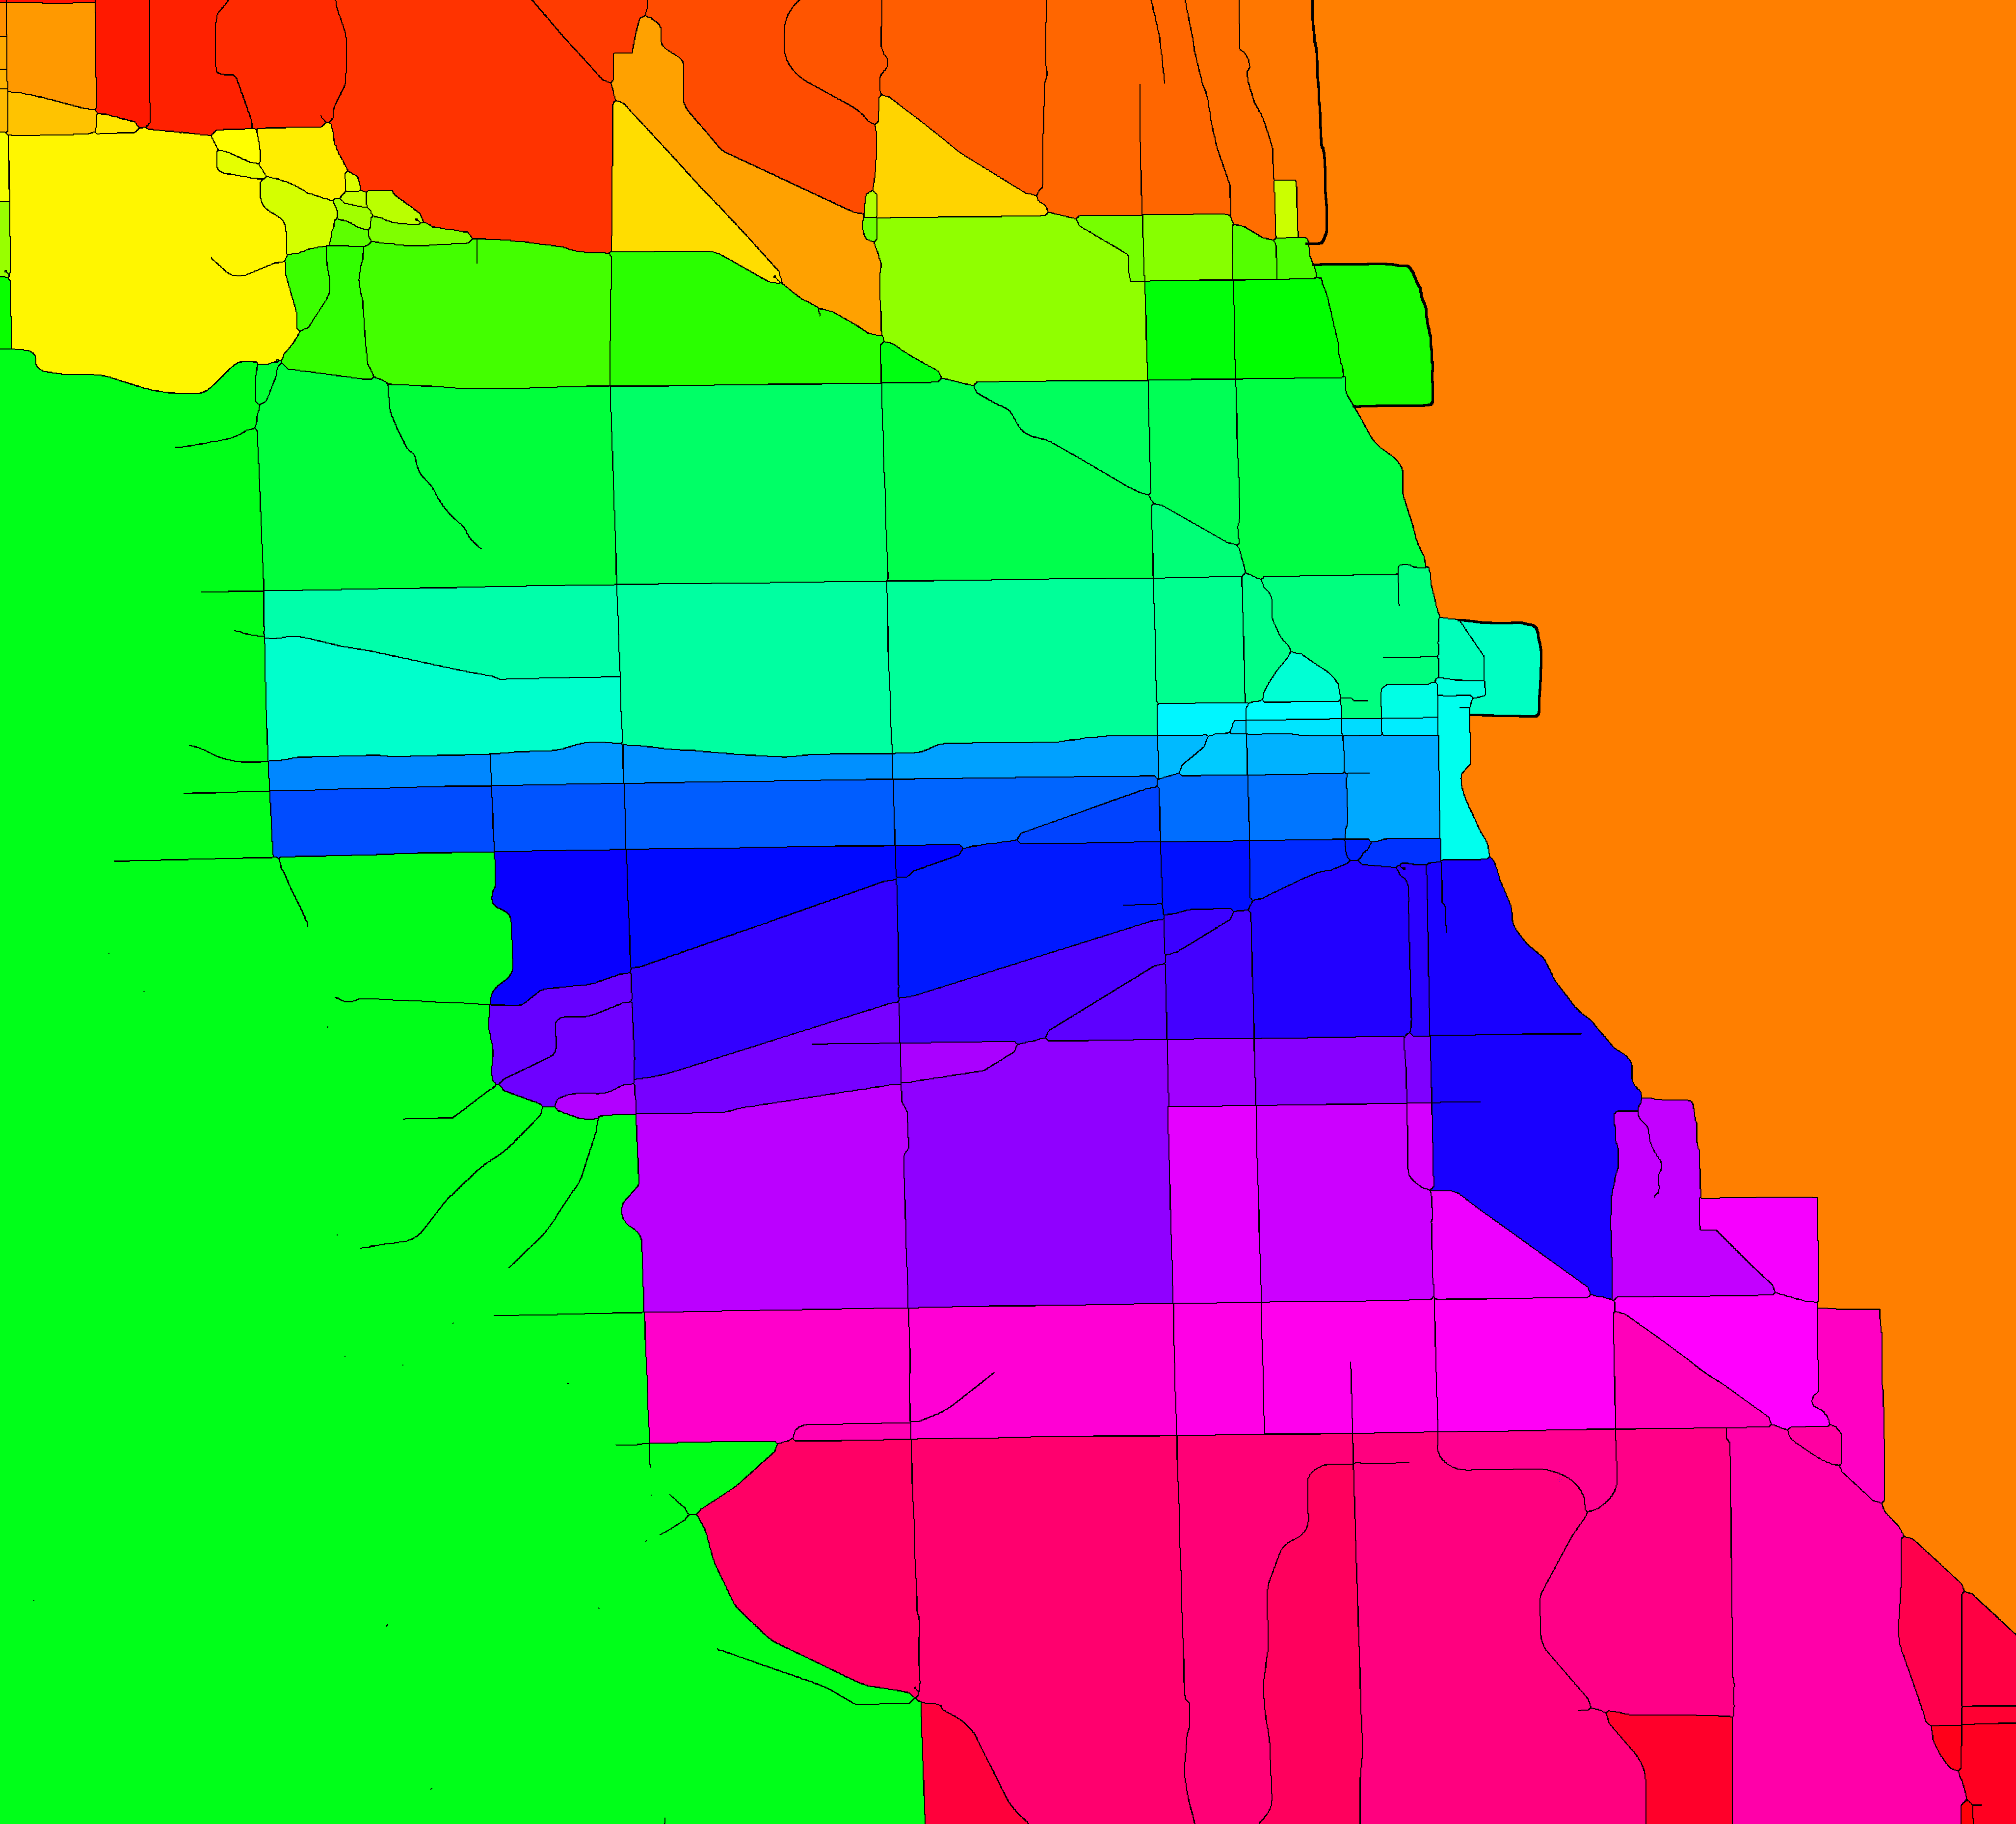

time: 904 ms


In [ ]:
testGPSMapping = [[41.711163976320314, -87.59736203586365] ]

testPixels = []
for elem in testGPSMapping:
  testPixels.append( gpsMapping(elem) )

print("Coordinates in pixels :", testPixels )
showGPSCoordinatesOnMap('chicago_labeled.png', [ testPixels[0] ] )

Zooming on one local region, we get:

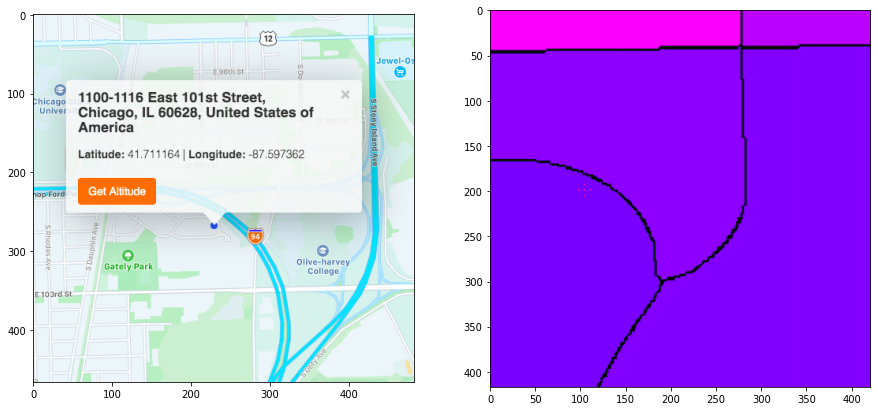

time: 488 ms


In [ ]:
local_image = cv2.imread("/content/realGPSMappingImage.png")
local_image_mapping = cv2.imread("/content/GPSMappingImagelocalview.png")
fig, axes = plt.subplots(1,2, figsize=(15, 15))
axes[0].imshow(local_image)
axes[1].imshow(local_image_mapping)

## **Mapping GPS coordinates to region IDs**

Before building the matrices, we need create a function for mapping GPS coordinates to region IDs. For more precision, we set a perimeter around the pixel positions given by the function built precedently. The region ID that appears the most inside that perimer will be the region ID for given GPS coordinates.

In [ ]:
def mostRepeatedRegionID(regionIDsList): 
  regionIDSCounter = Counter(regionIDsList)   # Returns all unique items and their counts
  return regionIDSCounter.most_common(1)[0][0]

def returnCleanedListFrom(labelArray):
  subLabelList = []
  for subLabelArray in labelArray:
    for elem in subLabelArray:
      if elem != 0:
        subLabelList.append(elem)
  return subLabelList

def returnNearestHorizontalRegionID(pixelCoordinates, perimeterRadius = 3):
  x, y = pixelCoordinates
  subRegion = labels_im[x:x+1,:y+1]
  j = max(y - perimeterRadius, 0)
  while j >= 0:
    regionID = subRegion[0][j]
    if regionID != 0 and regionID != 14:
      return regionID
    j = j - perimeterRadius
  return 14

def returnRegionIDforGPSCoordinates(gpsCoordinates, perimeterRadius = 2):
  x, y = gpsMapping(gpsCoordinates)
  n, m = labels_im.shape
  xmin = max(x - perimeterRadius, 0)
  xmax = min(x + perimeterRadius, n-1)
  ymin = max(y - perimeterRadius, 0)
  ymax = min(y + perimeterRadius, m-1)
  subRegion = labels_im[xmin:xmax+1, ymin:ymax+1]
  subLabelList = returnCleanedListFrom(labels_im[xmin:xmax+1, ymin:ymax+1])
  regionID = mostRepeatedRegionID(subLabelList)
  if regionID == 14:
    regionID = returnNearestHorizontalRegionID([x, y])                                
  return regionID

time: 25.4 ms


We try one example and check it's correcly maps GPS coordinates to region ID. In this example, it determines the region ID 142.

GPS Coordinates:  [41.72159618681185, -87.62435890150466]  , Region ID 142


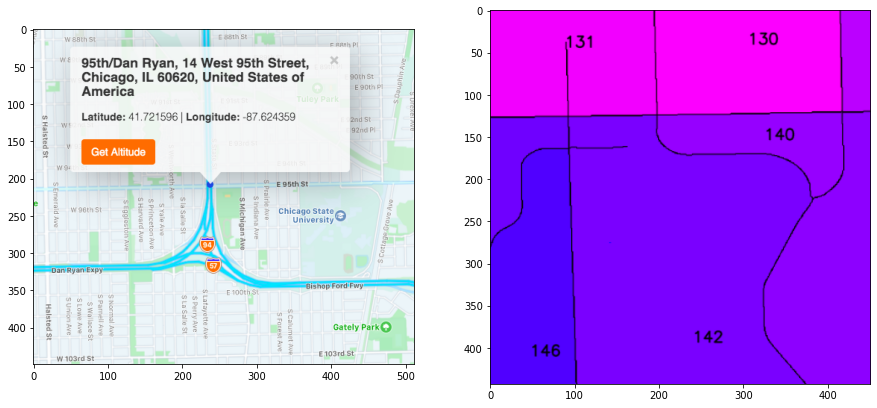

time: 512 ms


In [ ]:
regionID = returnRegionIDforGPSCoordinates(testGPSMapping[0])
print("GPS Coordinates: ", testGPSMapping[0], " , Region ID", regionID)

example_image = cv2.imread("/content/exampleGPSCoordinateMapping.png")
example_image_regionID = cv2.imread("/content/exampleRegionIDMapping.png")
fig, axes = plt.subplots(1,2, figsize=(15, 15))
axes[0].imshow(example_image)
axes[1].imshow(example_image_regionID)

## **Creating the end-new flows matrices**

In future steps, I will modelize taxi trips over high-level regions and by hour. Ideally, I will have a total of maximum 30 high-level regions. I selected 3 months of taxi trips to have a raisonable amount of data on which to build the high-level regions from the low-level regions.


The total amount of data will be 30 regions times 24 hours times 30 days times 3 months, for a total of 64,800 entries. and build a dataframe that contains taxi trips by region ID, by hour.

I select January, February, and March for year 2017 from Chicago Open Data. 

**Link:** https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew

In [ ]:
df_raw_jan = pd.read_feather('/content/gdrive/My Drive/urban-computing-project/taxi-jan-2017-raw')
df_raw_feb = pd.read_feather('/content/gdrive/My Drive/urban-computing-project/taxi-feb-2017-raw')
df_raw_mar = pd.read_feather('/content/gdrive/My Drive/urban-computing-project/taxi-mar-2017-raw')

time: 31.6 s


In [ ]:
df_raw_jan.head()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude
0,5cf20d1b3e95bd1fdcb7eb7fe6ffc4c3394f6c96,a4b608e480d78cdf6a1bf59575fd3290f346d0f06d0663...,2017-01-01T00:00:00.000,2017-01-01T00:15:00.000,613,1.1,17031081100,17031081401,Blue Diamond,41.900221297,-87.629105186,41.89503345,-87.619710672
1,7026741c331d4a048462a449849747a0cc7a0719,51a6c262c353a876d8b49b312079b8aed48c4a0cb117b8...,2017-01-01T00:00:00.000,2017-01-01T00:15:00.000,859,3.2,None,None,Blue Diamond,41.901206994,-87.676355989,41.938666196,-87.711210593
2,8758632d2fa799b4cc44a2b2cbf34a08464b5bfa,3284b3b2e25e89191c37917af7a46b6c87baf90075ce7a...,2017-01-01T00:00:00.000,2017-01-01T00:15:00.000,429,1,17031081700,17031839100,Blue Diamond,41.892042136,-87.63186395,41.880994471,-87.632746489
3,cea13d1ad7cb217a58d98f1fbf3e52932d9ca831,7d0bc378eb719b0ec2ebd3a591307cd31b29d9f8b1e551...,2017-01-01T00:00:00.000,2017-01-01T00:15:00.000,421,1.8,None,None,Blue Diamond,41.901206994,-87.676355989,41.938666196,-87.711210593
4,418021d6c816d59cfeffc5b53d8d7271378beb60,697ada6eb0299a4956ac3305adc75c5b45342ae7c7cd7f...,2017-01-01T00:00:00.000,2017-01-01T00:45:00.000,2327,4.2,17031081500,17031330100,Checker Taxi,41.892507781,-87.626214906,41.859349715,-87.617358006


time: 54.1 ms


The two types of flow are defined as the following:

**New-flow**: the traffic of crowds originating from a region at a given time interval. 

**End-flow**: the traffic of crowds terminated in a region 

New-flow and end-flow track the origins and final destinations of the crowds.

In [ ]:
df = df_raw_jan[['pickup_census_tract', 'dropoff_census_tract', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'trip_seconds', 'trip_start_timestamp', 'trip_end_timestamp']].copy()

df_feb = df_raw_feb[['pickup_census_tract', 'dropoff_census_tract', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'trip_seconds', 'trip_start_timestamp', 'trip_end_timestamp']].copy()

df_mar = df_raw_mar[['pickup_census_tract', 'dropoff_census_tract', 'pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude', 'trip_seconds', 'trip_start_timestamp', 'trip_end_timestamp']].copy()

time: 1.16 s


In [ ]:
df.head()

,pickup_census_tract,dropoff_census_tract,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,trip_seconds,trip_start_timestamp,trip_end_timestamp
0,17031081100,17031081401,41.900221297,-87.629105186,41.89503345,-87.619710672,613,2017-01-01T00:00:00.000,2017-01-01T00:15:00.000
1,None,None,41.901206994,-87.676355989,41.938666196,-87.711210593,859,2017-01-01T00:00:00.000,2017-01-01T00:15:00.000
2,17031081700,17031839100,41.892042136,-87.63186395,41.880994471,-87.632746489,429,2017-01-01T00:00:00.000,2017-01-01T00:15:00.000
3,None,None,41.901206994,-87.676355989,41.938666196,-87.711210593,421,2017-01-01T00:00:00.000,2017-01-01T00:15:00.000
4,17031081500,17031330100,41.892507781,-87.626214906,41.859349715,-87.617358006,2327,2017-01-01T00:00:00.000,2017-01-01T00:45:00.000


time: 31.4 ms


We remove taxi trips that don't contain a census tract for pickup or dropoff, or taxi trip time isn't available or below 10 seconds.

In [ ]:
print(df.shape)
df = df[ df.pickup_census_tract.notnull() ]
print(df.shape)
df = df[ df.dropoff_census_tract.notnull() ]
print(df.shape)
df['trip_seconds'] = pd.to_numeric(df['trip_seconds'])
df = df[ df.trip_seconds.notnull() ]
df = df[ df.trip_seconds >= 10. ]
print(df.shape)
df = df[ df.pickup_centroid_latitude.notnull() ]
print(df.shape)
df = df[ df.pickup_centroid_longitude.notnull() ]
print(df.shape)

df.head()

(1185201, 9)
(1185201, 9)
(1185201, 9)
(1185201, 9)
(1185201, 9)
(1185201, 9)


,pickup_census_tract,dropoff_census_tract,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,trip_seconds,trip_start_timestamp,trip_end_timestamp
0,17031081100,17031081401,41.900221,-87.629105,41.895033,-87.619711,613.0,2017-01-01T00:00:00.000,2017-01-01T00:15:00.000
2,17031081700,17031839100,41.892042,-87.631864,41.880994,-87.632746,429.0,2017-01-01T00:00:00.000,2017-01-01T00:15:00.000
4,17031081500,17031330100,41.892508,-87.626215,41.859350,-87.617358,2327.0,2017-01-01T00:00:00.000,2017-01-01T00:45:00.000
7,17031081300,17031081300,41.898332,-87.620763,41.898332,-87.620763,487.0,2017-01-01T00:00:00.000,2017-01-01T00:15:00.000
8,17031081202,17031839100,41.902788,-87.626146,41.880994,-87.632746,784.0,2017-01-01T00:00:00.000,2017-01-01T00:15:00.000


time: 557 ms


I create a function to do all the data preprocessing for future steps.

In [ ]:
def cleanTaxiTripsDataframe(taxiTripsDf):
  taxiTripsDf = taxiTripsDf[ taxiTripsDf.pickup_census_tract.notnull() ]
  taxiTripsDf = taxiTripsDf[ taxiTripsDf.dropoff_census_tract.notnull() ]
  taxiTripsDf['trip_seconds'] = pd.to_numeric(taxiTripsDf['trip_seconds'])
  taxiTripsDf = taxiTripsDf[ taxiTripsDf.trip_seconds.notnull() ]
  taxiTripsDf = taxiTripsDf[ taxiTripsDf.trip_seconds >= 10. ]
  taxiTripsDf = taxiTripsDf[ taxiTripsDf.pickup_centroid_latitude.notnull() ]
  taxiTripsDf = taxiTripsDf[ taxiTripsDf.pickup_centroid_longitude.notnull() ]
  taxiTripsDf = taxiTripsDf[ taxiTripsDf.dropoff_centroid_latitude.notnull() ]
  taxiTripsDf = taxiTripsDf[ taxiTripsDf.dropoff_centroid_longitude.notnull() ]
  taxiTripsDf['pickup_centroid_latitude'] = pd.to_numeric(taxiTripsDf['pickup_centroid_latitude'])
  taxiTripsDf['pickup_centroid_longitude'] = pd.to_numeric(taxiTripsDf['pickup_centroid_longitude'])
  taxiTripsDf['dropoff_centroid_latitude'] = pd.to_numeric(taxiTripsDf['dropoff_centroid_latitude'])
  taxiTripsDf['dropoff_centroid_longitude'] = pd.to_numeric(taxiTripsDf['dropoff_centroid_longitude'])
  taxiTripsDf = taxiTripsDf[ taxiTripsDf.trip_start_timestamp.notnull() ]
  taxiTripsDf = taxiTripsDf[ taxiTripsDf.trip_end_timestamp.notnull() ]
  return taxiTripsDf

time: 7.97 ms


In [ ]:
df = cleanTaxiTripsDataframe(df)

df_feb = cleanTaxiTripsDataframe(df_feb)

df_mar = cleanTaxiTripsDataframe(df_mar)

print(df.shape)

(1185201, 9)
time: 10.2 s


We create a new dataframe that will contain the region IDs for pickup and dropoff.

In [ ]:
regionID_df = pd.DataFrame()
regionID_df['pickup_centroid_latitude'] = df['pickup_centroid_latitude']
regionID_df['pickup_centroid_longitude'] = df['pickup_centroid_longitude']
regionID_df['dropoff_centroid_latitude'] = df['dropoff_centroid_latitude']
regionID_df['dropoff_centroid_longitude'] = df['dropoff_centroid_longitude']

#February
regionID_df_feb = pd.DataFrame()
regionID_df_feb['pickup_centroid_latitude'] = df_feb['pickup_centroid_latitude']
regionID_df_feb['pickup_centroid_longitude'] = df_feb['pickup_centroid_longitude']
regionID_df_feb['dropoff_centroid_latitude'] = df_feb['dropoff_centroid_latitude']
regionID_df_feb['dropoff_centroid_longitude'] = df_feb['dropoff_centroid_longitude']

#March
regionID_df_mar = pd.DataFrame()
regionID_df_mar['pickup_centroid_latitude'] = df_mar['pickup_centroid_latitude']
regionID_df_mar['pickup_centroid_longitude'] = df_mar['pickup_centroid_longitude']
regionID_df_mar['dropoff_centroid_latitude'] = df_mar['dropoff_centroid_latitude']
regionID_df_mar['dropoff_centroid_longitude'] = df_mar['dropoff_centroid_longitude']

time: 344 ms


In [ ]:
regionID_df.describe()

,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude
count,1.185201e+06,1.185201e+06,1.185201e+06,1.185201e+06
mean,4.189321e+01,-8.764900e+01,4.189398e+01,-8.764398e+01
std,2.872666e-02,6.499186e-02,2.617253e-02,5.149419e-02
min,4.171576e+01,-8.790304e+01,4.168156e+01,-8.790304e+01
25%,4.188099e+01,-8.764149e+01,4.188099e+01,-8.764265e+01
50%,4.189092e+01,-8.763275e+01,4.189092e+01,-8.763275e+01
75%,4.189503e+01,-8.762217e+01,4.189833e+01,-8.762217e+01
max,4.202122e+01,-8.756285e+01,4.202122e+01,-8.755199e+01


time: 206 ms


In [ ]:
print(regionID_df_mar[regionID_df_mar['pickup_centroid_latitude'].isnull()].count())
print(regionID_df_mar[regionID_df_mar['pickup_centroid_longitude'].isnull()].count())
print(regionID_df_mar[regionID_df_mar['dropoff_centroid_latitude'].isnull()].count())
print(regionID_df_mar[regionID_df_mar['dropoff_centroid_longitude'].isnull()].count())

pickup_centroid_latitude      0
pickup_centroid_longitude     0
dropoff_centroid_latitude     0
dropoff_centroid_longitude    0
dtype: int64
pickup_centroid_latitude      0
pickup_centroid_longitude     0
dropoff_centroid_latitude     0
dropoff_centroid_longitude    0
dtype: int64
pickup_centroid_latitude      0
pickup_centroid_longitude     0
dropoff_centroid_latitude     0
dropoff_centroid_longitude    0
dtype: int64
pickup_centroid_latitude      0
pickup_centroid_longitude     0
dropoff_centroid_latitude     0
dropoff_centroid_longitude    0
dtype: int64
time: 47.3 ms


In [ ]:
regionIDslist = []

regionID_13_data = []

for index, row in regionID_df.iterrows():
  x = row['pickup_centroid_latitude']
  y = row['pickup_centroid_longitude']
  pickup_regionID = returnRegionIDforGPSCoordinates([ x, y ])
  x = row['dropoff_centroid_latitude']
  y = row['dropoff_centroid_longitude']
  dropoff_regionID = returnRegionIDforGPSCoordinates([ x, y ])
  regionIDslist.append([pickup_regionID, dropoff_regionID])

  if pickup_regionID == 14 or dropoff_regionID == 14:
    regionID_13_data.append( [index, row['pickup_centroid_latitude'],row['pickup_centroid_longitude'], row['dropoff_centroid_latitude'], row['dropoff_centroid_longitude'] ])

time: 5min 18s


In [ ]:
regionIDslist_feb = []

for index, row in regionID_df_feb.iterrows():
  x = row['pickup_centroid_latitude']
  y = row['pickup_centroid_longitude']
  pickup_regionID = returnRegionIDforGPSCoordinates([ x, y ])
  x = row['dropoff_centroid_latitude']
  y = row['dropoff_centroid_longitude']
  dropoff_regionID = returnRegionIDforGPSCoordinates([ x, y ])
  regionIDslist_feb.append([pickup_regionID, dropoff_regionID])

#March
regionIDslist_mar = []

for index, row in regionID_df_mar.iterrows():
  x = row['pickup_centroid_latitude']
  y = row['pickup_centroid_longitude']
  pickup_regionID = returnRegionIDforGPSCoordinates([ x, y ])
  x = row['dropoff_centroid_latitude']
  y = row['dropoff_centroid_longitude']
  dropoff_regionID = returnRegionIDforGPSCoordinates([ x, y ])
  regionIDslist_mar.append([pickup_regionID, dropoff_regionID])

time: 12min 15s


### **Dealing with wrong mapping data**

Region 13 is considered on Lake Michigan and must be removed from the data before doing the modelling. 

We can resolve the issue or remove the data with region ID equal to 13. As we can see below, about 2.4% of the GPS coordinates data give region ID 13.

In [ ]:
print("Number of wrong coordinates: ", len(regionID_13_data))
print("As a percentage of total rows :", 100*len(regionID_13_data)/ regionID_df.pickup_centroid_latitude.count())

Number of wrong coordinates:  28838
As a percentage of total rows : 2.433173782337342
time: 7.74 ms


In [ ]:
region13GPSMapping = []

wrong_gps_coordinates = []

for elem in regionID_13_data:
  x = elem[1]
  y = elem[2]
  regionID = returnRegionIDforGPSCoordinates([ x, y ])
  if regionID == 13:
    region13GPSMapping.append( gpsMapping([x, y]) )
    wrong_gps_coordinates.append([x, y])
  x = elem[3]
  y = elem[4]
  regionID = returnRegionIDforGPSCoordinates([ x, y ])
  if regionID == 13:
    region13GPSMapping.append( gpsMapping([x, y]) )
    wrong_gps_coordinates.append([x, y])

In [ ]:
print("Number of wrong GPS coordinates :" , len(wrong_gps_coordinates))
latitude_list = []
longitude_list = []
counting = 0
for elem in wrong_gps_coordinates:
  if elem[0] not in latitude_list:
    latitude_list.append(elem[0])
  if elem[1] not in longitude_list:
    longitude_list.append(elem[1])
  if elem[0] == 42.004764559:
    counting = counting + 1
print("Wrong latitude list:", latitude_list)
print("Wrong longitude list:", longitude_list)
print("counting ", counting)

[41.891971508000005, -87.612945414]
[41.962178629, -87.645378762]
[41.962178629, -87.645378762]
[41.891971508000005, -87.612945414]
[41.891971508000005, -87.612945414]
Number of wrong GPS coordinates : 29394
Wrong latitude list: [41.891971508000005, 41.962178629, 42.004764559]
Wrong longitude list: [-87.612945414, -87.645378762, -87.65912242700001]
counting  96
time: 28.6 ms


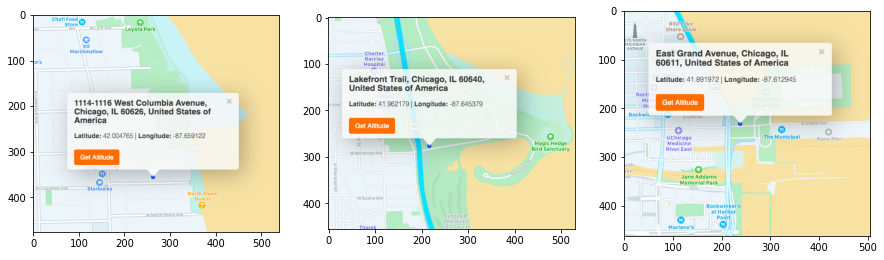

time: 601 ms


In [ ]:
wrong_location1 = cv2.imread("/content/wrong_coordinates_example1.png")
wrong_location2 = cv2.imread("/content/wrong_coordinates_example2.png")
wrong_location3 = cv2.imread("/content/wrong_coordinates_example3.png")
fig, axes = plt.subplots(1,3, figsize=(15, 15))
axes[0].imshow(wrong_location1)
axes[1].imshow(wrong_location2)
axes[2].imshow(wrong_location3)

In [ ]:
df_wrong_regionID_13 = regionID_df

df_wrong_regionID_13 = df_wrong_regionID_13[ (df_wrong_regionID_13.pickup_regionIDs == 13) | (df_wrong_regionID_13.dropoff_regionIDs == 13)] 

df_wrong_regionID_13.head()

,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,pickup_regionIDs,dropoff_regionIDs,pickup_timestamp,dropoff_timestamp,pickup_month,pickup_day,pickup_hour,dropoff_month,dropoff_day,dropoff_hour
31,41.891972,-87.612945,41.966834,-87.684018,13,52,2017-01-01T00:00:00.000,2017-01-01T00:30:00.000,1,1,0,1,1,0
86,41.877406,-87.621972,41.962179,-87.645379,75,13,2017-01-01T00:00:00.000,2017-01-01T00:30:00.000,1,1,0,1,1,0
188,41.877406,-87.621972,41.962179,-87.645379,75,13,2017-01-01T00:00:00.000,2017-01-01T00:30:00.000,1,1,0,1,1,0
189,41.922083,-87.634156,41.962179,-87.645379,58,13,2017-01-01T00:00:00.000,2017-01-01T00:15:00.000,1,1,0,1,1,0
403,41.880994,-87.632746,41.891972,-87.612945,74,13,2017-01-01T00:00:00.000,2017-01-01T00:45:00.000,1,1,0,1,1,0


time: 42.1 ms


In [ ]:
df_wrong_regionID_13.describe()

,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,pickup_regionIDs,dropoff_regionIDs,pickup_month,pickup_day,pickup_hour,dropoff_month,dropoff_day,dropoff_hour
count,28838.000000,28838.000000,28838.000000,28838.000000,28838.000000,28838.000000,28838.0,28838.000000,28838.000000,28838.0,28838.000000,28838.000000
mean,41.895384,-87.631751,41.897230,-87.626551,42.566267,37.776510,1.0,15.197309,14.548720,1.0,15.200257,14.654033
std,0.025093,0.047937,0.024792,0.033552,29.187578,28.750713,0.0,8.737536,5.229581,0.0,8.738570,5.267960
min,41.785999,-87.903040,41.785999,-87.903040,11.000000,11.000000,1.0,1.000000,0.000000,1.0,1.000000,0.000000
25%,41.890922,-87.632746,41.891972,-87.632109,13.000000,13.000000,1.0,7.000000,11.000000,1.0,7.000000,11.000000
50%,41.891972,-87.620763,41.891972,-87.618868,58.000000,13.000000,1.0,15.000000,15.000000,1.0,15.000000,16.000000
75%,41.892073,-87.612945,41.892073,-87.612945,70.000000,70.000000,1.0,23.000000,18.000000,1.0,23.000000,19.000000
max,42.009413,-87.583144,42.015934,-87.583144,123.000000,123.000000,1.0,30.000000,23.000000,1.0,30.000000,23.000000


time: 68.9 ms


The mapping returns a value of 13 for the region ID because the 3 GPS positions are located on the right hand side of the first vertical road segment from the right. That road segment acts as the "border" between the city and the Lake Michigan, and thus all GPS coordinates located on its right are misclassified.

As we can see from the 3 figures above, the 3 locations make sense. They are located on touristic regions or downtown Chicago, and therefore are relevant in the data.

To deal with that, given the conditions of the problem, I decided to modify the black and white image and draw new regions around those 3 GPS coordinates. Since two of them are located downtown Chicago and they have beaches as Points of Interest, they might have different taxi trips patterns than the neighboor regions. Therefore, it's best to create 3 new regions.

After the modification, performing another labeling, Lake Michigan is identified as region ID 14 (instead of 13).

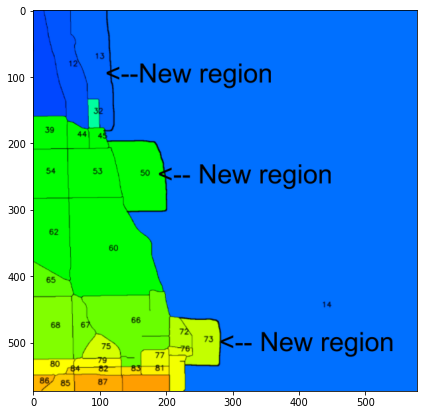

time: 247 ms


In [ ]:
new_regions_image = cv2.imread("/content/New_regions.png")

fig, axes = plt.subplots(1,1, figsize=(7, 7))
axes.imshow(new_regions_image)


Below, we verify that the GPS coordinates now fall inside the new regions.

In [ ]:
wrong_gps_coordinates = [[41.891971508000005, -87.612945414], [41.962178629, -87.645378762], [42.004764559, -87.65912242700001]]

for wrongGPSelem in wrong_gps_coordinates:
  print(returnRegionIDforGPSCoordinates(wrongGPSelem))

73
50
13
time: 2.27 ms


Now that the issue is fixed, we run again the function to map GPS coordinates to region IDs and check whether we got wrong region ID 13.

In [ ]:
print("Number of wrong GPS mapping: ", len(regionID_13_data))

Number of wrong GPS mapping:  0
time: 1.93 ms


Now, we can move to the next step.

### **Getting the region IDs for all taxi trips**

After we added the 3 new regions, I reruned all the codes since the labeling changed and modified the functions above accordingly. Below, we run again the code to get the region IDs associated to all taxi trips.

In [ ]:
regionIDslist = []

regionID_14_data = []

for index, row in regionID_df.iterrows():
  x = row['pickup_centroid_latitude']
  y = row['pickup_centroid_longitude']
  pickup_regionID = returnRegionIDforGPSCoordinates([ x, y ])
  x = row['dropoff_centroid_latitude']
  y = row['dropoff_centroid_longitude']
  dropoff_regionID = returnRegionIDforGPSCoordinates([ x, y ])
  regionIDslist.append([pickup_regionID, dropoff_regionID])

  if pickup_regionID == 14 or dropoff_regionID == 14:
    regionID_14_data.append( [index, row['pickup_centroid_latitude'],row['pickup_centroid_longitude'], row['dropoff_centroid_latitude'], row['dropoff_centroid_longitude'] ])

time: 5min 12s


In [ ]:
print("Number of GPS coordinates falling on region ID 14 (Lake Michigan): ", len(regionID_14_data))

Number of GPS coordinates falling on region ID 14 (Lake Michigan):  0
time: 1.14 ms


In [ ]:
pickup_regionIDs = []
dropoff_regionIDs = []
for elem in regionIDslist:
  pickup_regionIDs.append(elem[0])
  dropoff_regionIDs.append(elem[1])

#February
pickup_regionIDs_feb = []
dropoff_regionIDs_feb = []
for elem in regionIDslist_feb:
  pickup_regionIDs_feb.append(elem[0])
  dropoff_regionIDs_feb.append(elem[1])

#March
pickup_regionIDs_mar = []
dropoff_regionIDs_mar = []
for elem in regionIDslist_mar:
  pickup_regionIDs_mar.append(elem[0])
  dropoff_regionIDs_mar.append(elem[1])

time: 1.06 s


In [ ]:
regionID_df['pickup_regionIDs'] = pickup_regionIDs
regionID_df['dropoff_regionIDs'] = dropoff_regionIDs

#February
regionID_df_feb['pickup_regionIDs'] = pickup_regionIDs_feb
regionID_df_feb['dropoff_regionIDs'] = dropoff_regionIDs_feb

#March
regionID_df_mar['pickup_regionIDs'] = pickup_regionIDs_mar
regionID_df_mar['dropoff_regionIDs'] = dropoff_regionIDs_mar

regionID_df_mar.head()

,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,pickup_regionIDs,dropoff_regionIDs
2,41.880994,-87.632746,41.920452,-87.679955,77,65
4,41.880994,-87.632746,41.892658,-87.652534,77,66
7,41.880994,-87.632746,41.890922,-87.618868,77,72
10,41.902788,-87.626146,41.885300,-87.642808,66,66
17,41.979071,-87.903040,41.904935,-87.649907,26,66


time: 2.12 s


In [ ]:
import datetime

def extractHour(taxiTripTimeStamp):
  date_time_obj = datetime.datetime.strptime(taxiTripTimeStamp, '%Y-%m-%dT%H:%M:%S.%f')
  return date_time_obj.hour

def extractDay(taxiTripTimeStamp):
  date_time_obj = datetime.datetime.strptime(taxiTripTimeStamp, '%Y-%m-%dT%H:%M:%S.%f')
  return date_time_obj.day

def extractMonth(taxiTripTimeStamp):
  date_time_obj = datetime.datetime.strptime(taxiTripTimeStamp, '%Y-%m-%dT%H:%M:%S.%f')
  return date_time_obj.month

def parseTaxiTripTimeStamp(taxiTripTimeStamp):
  parsedtaxiTripTimeStamp =  [extractMonth(taxiTripTimeStamp), extractDay(taxiTripTimeStamp), extractHour(taxiTripTimeStamp)]
  return parsedtaxiTripTimeStamp

time: 4.83 ms


In [ ]:
regionID_df['pickup_timestamp'] = df['trip_start_timestamp']
regionID_df['dropoff_timestamp'] = df['trip_end_timestamp']

#February
regionID_df_feb['pickup_timestamp'] = df_feb['trip_start_timestamp']
regionID_df_feb['dropoff_timestamp'] = df_feb['trip_end_timestamp']

#March
regionID_df_mar['pickup_timestamp'] = df_mar['trip_start_timestamp']
regionID_df_mar['dropoff_timestamp'] = df_mar['trip_end_timestamp']

time: 76.9 ms


In [ ]:
#pickup
regionID_df['pickup_month'] = df.apply (lambda row: extractMonth(row["trip_start_timestamp"]), axis=1)
regionID_df['pickup_day'] = df.apply (lambda row: extractDay(row["trip_start_timestamp"]), axis=1)
regionID_df['pickup_hour'] = df.apply (lambda row: extractHour(row["trip_start_timestamp"]), axis=1)

#dropoff
regionID_df['dropoff_month'] = df.apply (lambda row: extractMonth(row["trip_end_timestamp"]), axis=1)
regionID_df['dropoff_day'] = df.apply (lambda row: extractDay(row["trip_end_timestamp"]), axis=1)
regionID_df['dropoff_hour'] = df.apply (lambda row: extractHour(row["trip_end_timestamp"]), axis=1)


#February
#pickup
regionID_df_feb['pickup_month'] = df_feb.apply (lambda row: extractMonth(row["trip_start_timestamp"]), axis=1)
regionID_df_feb['pickup_day'] = df_feb.apply (lambda row: extractDay(row["trip_start_timestamp"]), axis=1)
regionID_df_feb['pickup_hour'] = df_feb.apply (lambda row: extractHour(row["trip_start_timestamp"]), axis=1)

#dropoff
regionID_df_feb['dropoff_month'] = df_feb.apply (lambda row: extractMonth(row["trip_end_timestamp"]), axis=1)
regionID_df_feb['dropoff_day'] = df_feb.apply (lambda row: extractDay(row["trip_end_timestamp"]), axis=1)
regionID_df_feb['dropoff_hour'] = df_feb.apply (lambda row: extractHour(row["trip_end_timestamp"]), axis=1)


#March
#pickup
regionID_df_mar['pickup_month'] = df_mar.apply (lambda row: extractMonth(row["trip_start_timestamp"]), axis=1)
regionID_df_mar['pickup_day'] = df_mar.apply (lambda row: extractDay(row["trip_start_timestamp"]), axis=1)
regionID_df_mar['pickup_hour'] = df_mar.apply (lambda row: extractHour(row["trip_start_timestamp"]), axis=1)

#dropoff
regionID_df_mar['dropoff_month'] = df_mar.apply (lambda row: extractMonth(row["trip_end_timestamp"]), axis=1)
regionID_df_mar['dropoff_day'] = df_mar.apply (lambda row: extractDay(row["trip_end_timestamp"]), axis=1)
regionID_df_mar['dropoff_hour'] = df_mar.apply (lambda row: extractHour(row["trip_end_timestamp"]), axis=1)

regionID_df.describe()

,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,pickup_regionIDs,dropoff_regionIDs,pickup_month,pickup_day,pickup_hour,dropoff_month,dropoff_day,dropoff_hour
count,1.185201e+06,1.185201e+06,1.185201e+06,1.185201e+06,1.185201e+06,1.185201e+06,1185201.0,1.185201e+06,1.185201e+06,1185201.0,1.185201e+06,1.185201e+06
mean,4.189321e+01,-8.764900e+01,4.189398e+01,-8.764398e+01,7.033962e+01,7.043587e+01,1.0,1.575532e+01,1.370860e+01,1.0,1.575920e+01,1.380511e+01
std,2.872666e-02,6.499186e-02,2.617253e-02,5.149419e-02,1.451789e+01,1.245208e+01,0.0,8.347241e+00,5.754360e+00,0.0,8.347900e+00,5.795732e+00
min,4.171576e+01,-8.790304e+01,4.168156e+01,-8.790304e+01,8.000000e+00,6.000000e+00,1.0,1.000000e+00,0.000000e+00,1.0,1.000000e+00,0.000000e+00
25%,4.188099e+01,-8.764149e+01,4.188099e+01,-8.764265e+01,6.600000e+01,6.600000e+01,1.0,9.000000e+00,1.000000e+01,1.0,9.000000e+00,1.000000e+01
50%,4.189092e+01,-8.763275e+01,4.189092e+01,-8.763275e+01,7.200000e+01,7.200000e+01,1.0,1.600000e+01,1.400000e+01,1.0,1.600000e+01,1.500000e+01
75%,4.189503e+01,-8.762217e+01,4.189833e+01,-8.762217e+01,7.700000e+01,7.700000e+01,1.0,2.300000e+01,1.800000e+01,1.0,2.300000e+01,1.800000e+01
max,4.202122e+01,-8.756285e+01,4.202122e+01,-8.755199e+01,1.440000e+02,1.460000e+02,1.0,3.100000e+01,2.300000e+01,1.0,3.100000e+01,2.300000e+01


time: 11min 13s


In [ ]:
regionID_df_feb.describe()

,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,pickup_regionIDs,dropoff_regionIDs,pickup_month,pickup_day,pickup_hour,dropoff_month,dropoff_day,dropoff_hour
count,1.207845e+06,1.207845e+06,1.207845e+06,1.207845e+06,1.207845e+06,1.207845e+06,1.207845e+06,1.207845e+06,1.207845e+06,1.207845e+06,1.207845e+06,1.207845e+06
mean,4.189263e+01,-8.764851e+01,4.189375e+01,-8.764452e+01,7.059885e+01,7.053146e+01,1.964893e+00,1.468011e+01,1.395167e+01,1.964943e+00,1.468270e+01,1.404627e+01
std,2.861808e-02,6.471149e-02,2.673380e-02,5.295414e-02,1.454629e+01,1.281934e+01,1.840507e-01,8.292157e+00,5.670747e+00,1.839231e-01,8.292096e+00,5.719181e+00
min,4.173417e+01,-8.790304e+01,4.171576e+01,-8.790304e+01,1.100000e+01,6.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,4.188099e+01,-8.763784e+01,4.188099e+01,-8.764265e+01,6.600000e+01,6.600000e+01,2.000000e+00,8.000000e+00,1.000000e+01,2.000000e+00,8.000000e+00,1.000000e+01
50%,4.188530e+01,-8.763211e+01,4.189092e+01,-8.763275e+01,7.200000e+01,7.200000e+01,2.000000e+00,1.500000e+01,1.500000e+01,2.000000e+00,1.500000e+01,1.500000e+01
75%,4.189503e+01,-8.762217e+01,4.189833e+01,-8.762217e+01,7.700000e+01,7.700000e+01,2.000000e+00,2.200000e+01,1.800000e+01,2.000000e+00,2.200000e+01,1.900000e+01
max,4.202122e+01,-8.758237e+01,4.202122e+01,-8.754664e+01,1.340000e+02,1.440000e+02,2.000000e+00,3.100000e+01,2.300000e+01,2.000000e+00,3.100000e+01,2.300000e+01


time: 530 ms


In [ ]:
regionID_df_mar.describe()

,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,pickup_regionIDs,dropoff_regionIDs,pickup_month,pickup_day,pickup_hour,dropoff_month,dropoff_day,dropoff_hour
count,1.564032e+06,1.564032e+06,1.564032e+06,1.564032e+06,1.564032e+06,1.564032e+06,1.564032e+06,1.564032e+06,1.564032e+06,1.564032e+06,1.564032e+06,1.564032e+06
mean,4.189264e+01,-8.764952e+01,4.189363e+01,-8.764557e+01,7.059725e+01,7.059248e+01,2.969224e+00,1.598655e+01,1.414031e+01,2.969341e+00,1.598760e+01,1.424317e+01
std,2.956838e-02,6.664401e-02,2.778157e-02,5.540529e-02,1.501712e+01,1.338451e+01,1.727092e-01,8.692954e+00,5.551465e+00,1.723910e-01,8.693189e+00,5.605000e+00
min,4.168461e+01,-8.790304e+01,4.168461e+01,-8.790304e+01,6.000000e+00,6.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00
25%,4.188099e+01,-8.763857e+01,4.188099e+01,-8.764265e+01,6.600000e+01,6.600000e+01,3.000000e+00,9.000000e+00,1.000000e+01,3.000000e+00,9.000000e+00,1.000000e+01
50%,4.188530e+01,-8.763186e+01,4.189092e+01,-8.763275e+01,7.200000e+01,7.200000e+01,3.000000e+00,1.600000e+01,1.500000e+01,3.000000e+00,1.600000e+01,1.500000e+01
75%,4.189503e+01,-8.762197e+01,4.189833e+01,-8.762217e+01,7.700000e+01,7.700000e+01,3.000000e+00,2.300000e+01,1.800000e+01,3.000000e+00,2.300000e+01,1.900000e+01
max,4.201605e+01,-8.754040e+01,4.202122e+01,-8.754040e+01,1.470000e+02,1.460000e+02,3.000000e+00,3.100000e+01,2.300000e+01,3.000000e+00,3.100000e+01,2.300000e+01


time: 669 ms


After some data processing, we are now ready to structure the data accordingly. We need:

1. a matrix that contains the pair (new-flow, end-flow) during the period, for a given region ID.
2. a similarity matrix containing the correlation between two connected region IDs.

**1 - Matrix containing the two flows over the period**

We order and remove duplicate from the arrays pickup_regionIDs and dropoff_regionIDs to build the matrix. They will also be combined into a single array for the mapping with the graph_matrix built in the previous notebook.

In [ ]:
pickup_regionIDs = list(dict.fromkeys(pickup_regionIDs))
dropoff_regionIDs = list(dict.fromkeys(dropoff_regionIDs))

pickup_regionIDs.sort(reverse=False)
dropoff_regionIDs.sort(reverse=False)

allRegionIDs = pickup_regionIDs + dropoff_regionIDs
allRegionIDs = list(dict.fromkeys(allRegionIDs))
allRegionIDs.sort(reverse=False)

print("Number of unique pickup region IDs: ", len(pickup_regionIDs))
print("Pickup region IDs: ", pickup_regionIDs)
print()
print("Number of unique dropoff region IDs: ", len(dropoff_regionIDs))
print("Dropoff region IDs: ", dropoff_regionIDs)
print()

Number of unique pickup region IDs:  67
Pickup region IDs:  [8, 11, 12, 13, 17, 22, 23, 26, 31, 32, 38, 39, 41, 44, 45, 46, 49, 50, 53, 54, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 80, 82, 83, 85, 87, 88, 89, 93, 94, 95, 99, 100, 101, 103, 104, 108, 109, 110, 112, 115, 120, 121, 123, 125, 126, 127, 130, 132, 133, 144]

Number of unique dropoff region IDs:  76
Dropoff region IDs:  [6, 8, 11, 12, 13, 17, 22, 23, 26, 31, 32, 38, 39, 41, 44, 45, 46, 49, 50, 53, 54, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 80, 82, 83, 85, 86, 87, 88, 89, 91, 93, 94, 95, 100, 101, 103, 108, 109, 110, 112, 113, 114, 115, 120, 121, 123, 125, 126, 127, 130, 131, 132, 133, 134, 135, 144, 145, 146]

time: 232 ms


In [ ]:
pickup_regionIDs_feb = list(dict.fromkeys(pickup_regionIDs_feb))
dropoff_regionIDs_feb = list(dict.fromkeys(dropoff_regionIDs_feb))

pickup_regionIDs_feb.sort(reverse=False)
dropoff_regionIDs_feb.sort(reverse=False)

allRegionIDs_feb = pickup_regionIDs_feb + dropoff_regionIDs_feb
allRegionIDs_feb = list(dict.fromkeys(allRegionIDs_feb))
allRegionIDs_feb.sort(reverse=False)

print("Number of unique pickup region IDs: ", len(pickup_regionIDs_feb))
print("Pickup region IDs: ", pickup_regionIDs_feb)
print()
print("Number of unique dropoff region IDs: ", len(dropoff_regionIDs_feb))
print("Dropoff region IDs: ", dropoff_regionIDs_feb)
print()

Number of unique pickup region IDs:  53
Pickup region IDs:  [11, 12, 13, 17, 26, 31, 32, 38, 39, 41, 44, 45, 46, 49, 50, 53, 54, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 72, 73, 75, 76, 77, 78, 80, 82, 83, 85, 87, 88, 89, 93, 94, 100, 108, 109, 110, 112, 114, 125, 126, 127, 130, 134]

Number of unique dropoff region IDs:  71
Dropoff region IDs:  [6, 8, 11, 12, 13, 17, 22, 23, 26, 31, 32, 38, 39, 41, 44, 45, 46, 49, 50, 53, 54, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 72, 73, 75, 76, 77, 78, 80, 82, 83, 85, 87, 88, 89, 91, 93, 94, 95, 99, 100, 101, 103, 104, 108, 109, 110, 112, 113, 114, 120, 121, 125, 126, 129, 130, 132, 133, 134, 136, 144]

time: 174 ms


In [ ]:
pickup_regionIDs_mar = list(dict.fromkeys(pickup_regionIDs_mar))
dropoff_regionIDs_mar = list(dict.fromkeys(dropoff_regionIDs_mar))

pickup_regionIDs_mar.sort(reverse=False)
dropoff_regionIDs_mar.sort(reverse=False)

allRegionIDs_mar = pickup_regionIDs_mar + dropoff_regionIDs_mar
allRegionIDs_mar = list(dict.fromkeys(allRegionIDs_mar))
allRegionIDs_mar.sort(reverse=False)

print("Number of unique pickup region IDs: ", len(pickup_regionIDs_mar))
print("Pickup region IDs: ", pickup_regionIDs_mar)
print()
print("Number of unique dropoff region IDs: ", len(dropoff_regionIDs_mar))
print("Dropoff region IDs: ", dropoff_regionIDs_mar)
print()

Number of unique pickup region IDs:  58
Pickup region IDs:  [6, 11, 12, 13, 17, 23, 26, 31, 32, 38, 39, 41, 44, 45, 46, 49, 50, 53, 54, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 72, 73, 75, 76, 77, 78, 80, 82, 83, 85, 87, 88, 93, 94, 100, 101, 103, 108, 110, 112, 123, 125, 126, 127, 130, 133, 141, 146, 147]

Number of unique dropoff region IDs:  72
Dropoff region IDs:  [6, 8, 11, 12, 13, 17, 22, 23, 26, 31, 32, 38, 39, 41, 44, 45, 46, 49, 50, 53, 54, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 72, 73, 75, 76, 77, 78, 80, 82, 83, 85, 86, 87, 88, 89, 91, 93, 94, 95, 99, 100, 101, 103, 104, 108, 109, 110, 112, 114, 115, 118, 123, 125, 126, 127, 130, 131, 133, 134, 135, 141, 146]

time: 203 ms


**IMPORTANT I need to create one single array containing the list of all region IDs where a taxi trip happened between January 1st to end of March 2017.**

In [ ]:
jan_feb_mar_all_region_IDs = allRegionIDs + allRegionIDs_feb + allRegionIDs_mar

jan_feb_mar_all_region_IDs = list(dict.fromkeys(jan_feb_mar_all_region_IDs))

jan_feb_mar_all_region_IDs.sort(reverse=False)

print("Total different region IDs: ", len(jan_feb_mar_all_region_IDs))
print("All region IDs for the period: ", jan_feb_mar_all_region_IDs)

Total different region IDs:  83
All region IDs for the period:  [6, 8, 11, 12, 13, 17, 22, 23, 26, 31, 32, 38, 39, 41, 44, 45, 46, 49, 50, 53, 54, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 80, 82, 83, 85, 86, 87, 88, 89, 91, 93, 94, 95, 99, 100, 101, 103, 104, 108, 109, 110, 112, 113, 114, 115, 118, 120, 121, 123, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 141, 144, 145, 146, 147]
time: 2.95 ms


Now, we create the basis vector that will contain the number of flows (new-flows or end-flows) per hour from January 1st to Janruary 31st 2017. 

The first element in the vector is Midnight Jan 1st, the second element is 1AM Jan 1st, the third is 2AM Jan 1st, etc.

In [ ]:
import calendar

year = 2017
start_month = 1 #starting in January
number_hour_per_day = 24
number_days = 31
hourly_vector_size = number_hour_per_day * number_days

def returnLastMonthInDataset():
  return regionID_df_mar['pickup_month'].max()

def mappingFromTimestampToHourlyVector(taxiTripTimestamp):
  index = -1
  month = taxiTripTimestamp[0]
  i = month - 1
  number_days_total = taxiTripTimestamp[1]
  number_hours = taxiTripTimestamp[2]
  while i > 0:
    number_days_total = number_days_total + calendar.monthrange(year, i)[1]
    i = i - 1
  index = number_hours + ( number_days_total - 1 ) * number_hour_per_day
  
  return index

def returnInitialHourlyVector():
  number_days_total = 0
  i = returnLastMonthInDataset()
  while i > 0:
    number_days_total = number_days_total + calendar.monthrange(year, i)[1]
    i = i - 1
  totalHours = number_days_total * number_hour_per_day
  hourlyVector = [[0, 0]] * totalHours

  return hourlyVector

test_month = 4
test_day = 7
test_hour = 0

print( "index = ", mappingFromTimestampToHourlyVector([ test_month, test_day, test_hour]) )

print("last month :", returnLastMonthInDataset())

initialHourlyVector = returnInitialHourlyVector()
print("Empty vector size:", len(initialHourlyVector))
print("First element in empty vector:", initialHourlyVector[0])

index =  2304
last month : 3
Empty vector size: 2160
First element in empty vector: [0, 0]
time: 26.3 ms


We fill up the hourly new-end flow vector for each region ID.

In [ ]:
initialHourlyVector = returnInitialHourlyVector()
newEndFlowstimeSeries = [[[0,0] for j in range(len(initialHourlyVector))] for i in range(len(jan_feb_mar_all_region_IDs))]

rowLength = len(newEndFlowstimeSeries)
columnLength = len(newEndFlowstimeSeries[0])

def returnIndexForRegionID(regionIDValue):
  return jan_feb_mar_all_region_IDs.index(regionIDValue)

def incrementMatrixWith(pickupRegionIDIndex, pickupHourIndex, dropoffRegionIDIndex, dropoffHourIndex):
  if pickupRegionIDIndex < rowLength and pickupHourIndex < columnLength:
    currentvalue = newEndFlowstimeSeries[pickupRegionIDIndex][pickupHourIndex][0]
    newEndFlowstimeSeries[pickupRegionIDIndex][pickupHourIndex][0] = currentvalue + 1
  
  if dropoffRegionIDIndex < rowLength and dropoffHourIndex < columnLength:
    currentvalue = newEndFlowstimeSeries[dropoffRegionIDIndex][dropoffHourIndex][1]
    newEndFlowstimeSeries[dropoffRegionIDIndex][dropoffHourIndex][1]  = currentvalue + 1

for index, row in regionID_df.iterrows():
  pickupTimestamp = [ row['pickup_month'], row['pickup_day'], row['pickup_hour']]
  pickupHourlyIndex = mappingFromTimestampToHourlyVector(pickupTimestamp)
  pickupIndex = returnIndexForRegionID( row['pickup_regionIDs'] )

  dropoffTimestamp = [ row['dropoff_month'], row['dropoff_day'], row['dropoff_hour']]
  dropoffHourlyIndex = mappingFromTimestampToHourlyVector(dropoffTimestamp)
  dropoffIndex = returnIndexForRegionID( row['dropoff_regionIDs'] )

  incrementMatrixWith(pickupIndex, pickupHourlyIndex, dropoffIndex, dropoffHourlyIndex)


time: 5min 36s


In [ ]:
for index, row in regionID_df_feb.iterrows():
  pickupTimestamp = [ row['pickup_month'], row['pickup_day'], row['pickup_hour']]
  pickupHourlyIndex = mappingFromTimestampToHourlyVector(pickupTimestamp)
  pickupIndex = returnIndexForRegionID( row['pickup_regionIDs'] )

  dropoffTimestamp = [ row['dropoff_month'], row['dropoff_day'], row['dropoff_hour']]
  dropoffHourlyIndex = mappingFromTimestampToHourlyVector(dropoffTimestamp)
  dropoffIndex = returnIndexForRegionID( row['dropoff_regionIDs'] )

  incrementMatrixWith(pickupIndex, pickupHourlyIndex, dropoffIndex, dropoffHourlyIndex)


for index, row in regionID_df_mar.iterrows():
  pickupTimestamp = [ row['pickup_month'], row['pickup_day'], row['pickup_hour']]
  pickupHourlyIndex = mappingFromTimestampToHourlyVector(pickupTimestamp)
  pickupIndex = returnIndexForRegionID( row['pickup_regionIDs'] )

  dropoffTimestamp = [ row['dropoff_month'], row['dropoff_day'], row['dropoff_hour']]
  dropoffHourlyIndex = mappingFromTimestampToHourlyVector(dropoffTimestamp)
  dropoffIndex = returnIndexForRegionID( row['dropoff_regionIDs'] )

  incrementMatrixWith(pickupIndex, pickupHourlyIndex, dropoffIndex, dropoffHourlyIndex)

time: 13min 18s


In [ ]:
print("All region IDs: ", jan_feb_mar_all_region_IDs)

All region IDs:  [6, 8, 11, 12, 13, 17, 22, 23, 26, 31, 32, 38, 39, 41, 44, 45, 46, 49, 50, 53, 54, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 80, 82, 83, 85, 86, 87, 88, 89, 91, 93, 94, 95, 99, 100, 101, 103, 104, 108, 109, 110, 112, 113, 114, 115, 118, 120, 121, 123, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 141, 144, 145, 146, 147]
time: 1.43 ms


In [ ]:
def returnWeightForRegionID(regionIDmapNumber):
  regionIDindex = returnIndexForRegionID( regionIDmapNumber )
  regionIDweight = 0
  for newEndflow in newEndFlowstimeSeries[regionIDindex]:
    regionIDweight = regionIDweight + newEndflow[0] + newEndflow[1]
  
  return regionIDweight

def returnWeightArrayForAllRegionIDs():
  regionIDsWeightArray = []
  for regionIDvalue in jan_feb_mar_all_region_IDs:
    regionIDsWeightArray.append(returnWeightForRegionID(regionIDvalue))
  
  return regionIDsWeightArray

def returnFilteredWeightArray(taxiTripsMinimum, regionIDsWeightArray):
  filteredWeightArray = []
  n = len(regionIDsWeightArray)
  i = 0
  while i < n:
    if regionIDsWeightArray[i] >= taxiTripsMinimum: 
      filteredWeightArray.append([regionIDsWeightArray[i], jan_feb_mar_all_region_IDs[i]])
    i = i + 1
  return filteredWeightArray


time: 9.36 ms


In [ ]:
taxi_Trips_Minimum_Array = [9000, 15000, 20000, 30000, 40000, 50000]

weightArray = returnWeightArrayForAllRegionIDs()
print("Weight array for all regions :", weightArray)

for taxi_Trips_Minimum in taxi_Trips_Minimum_Array:
  filteredweightArray = returnFilteredWeightArray(taxi_Trips_Minimum, weightArray)
  print("Minimum Taxi trips: ", taxi_Trips_Minimum)
  print("filtered weight array: ", filteredweightArray)
  print("Number of regions :", len(filteredweightArray))
  print()

Weight array for all regions : [23, 39, 3405, 3383, 323, 361, 13, 39, 361540, 13290, 1124, 3810, 2303, 95, 1933, 2353, 1038, 258, 9573, 26650, 8111, 3, 456156, 11698, 15904, 1762, 1263, 17934, 2508920, 21019, 59164, 3185, 8, 741868, 94857, 153903, 707920, 1383333, 489263, 30125, 63590, 421942, 15731, 7, 1784, 85357, 39, 4, 978, 225, 30, 12, 61837, 120, 39, 16, 7581, 219, 88, 4396, 5, 15, 15, 2, 6, 12, 18, 106102, 5918, 14, 1, 17, 5, 9, 30, 6, 7, 1, 14, 4, 2, 8, 1]
Minimum Taxi trips:  9000
filtered weight array:  [[361540, 26], [13290, 31], [9573, 50], [26650, 53], [456156, 60], [11698, 61], [15904, 62], [17934, 65], [2508920, 66], [21019, 67], [59164, 68], [741868, 72], [94857, 73], [153903, 75], [707920, 76], [1383333, 77], [489263, 78], [30125, 80], [63590, 82], [421942, 83], [15731, 85], [85357, 88], [61837, 100], [106102, 125]]
Number of regions : 24

Minimum Taxi trips:  15000
filtered weight array:  [[361540, 26], [26650, 53], [456156, 60], [15904, 62], [17934, 65], [2508920, 66

In [ ]:
newEndFlowstimeSeries_copy = newEndFlowstimeSeries

newEndFlowstimeSeries_array = []

for arrayelem in newEndFlowstimeSeries_copy:
  newEndFlowstimeSeries_array_elem = []
  for elem in arrayelem:
    newEndFlowstimeSeries_array_elem.append(elem[0])
    newEndFlowstimeSeries_array_elem.append(elem[1])
  newEndFlowstimeSeries_array.append(newEndFlowstimeSeries_array_elem)

In [ ]:
#We save the labels, centroids and graph matrices for next steps 
from numpy import asarray
from numpy import savetxt
# define data

data = asarray( newEndFlowstimeSeries_array )
# save to csv file
savetxt('/content/gdrive/My Drive/urban-computing-project/newEndFlowstimeSeries_2.csv', data, delimiter=';')

time: 234 ms


# **2nd Part**


We get the results from the saved work above. 

In [ ]:
from numpy import loadtxt
# load array
data = loadtxt('/content/gdrive/My Drive/urban-computing-project/newEndFlowstimeSeries_2.csv', delimiter=';')

time: 264 ms


In [ ]:
allRegionsIDJanFebMar = [6, 8, 11, 12, 13, 17, 22, 23, 26, 31, 32, 38, 39, 41, 44, 45, 46, 49, 50, 53, 54, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 80, 82, 83, 85, 86, 87, 88, 89, 91, 93, 94, 95, 99, 100, 101, 103, 104, 108, 109, 110, 112, 113, 114, 115, 118, 120, 121, 123, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 141, 144, 145, 146, 147]

def returnIndexForRegionID(regionIDValue):
  return allRegionsIDJanFebMar.index(regionIDValue)

def rebuildMatrixForTImeSeries(retrievedData):
  retrievedTimeSeriesArray = []
  n = len(retrievedData[0])
  for regionTimeSeriesArray in retrievedData:
    i = 0
    regionNewEndFlowTimeSeries = []
    while i < n:
      regionNewEndFlowTimeSeries.append([regionTimeSeriesArray[i], regionTimeSeriesArray[i + 1]])
      i = i + 2
    retrievedTimeSeriesArray.append(regionNewEndFlowTimeSeries)

  return retrievedTimeSeriesArray

time: 12 ms


**We build functions to plot each region separately, with options to select the time interval.**

In [ ]:
def returnNewFlowTimeSeriesFor(regionIDTimeSeriesToRetrieve, timeSeriesLastIndex, timeSeriesStartIndex = 0):
  if timeSeriesLastIndex >= len(allRegionsTimeSeriesArray[0]):
    timeSeriesLastIndex = len(allRegionsTimeSeriesArray[0])
  regionID_index_ = returnIndexForRegionID( regionIDTimeSeriesToRetrieve )
  newFlowTimeSeries = []
  for i, timeSeriesElem in enumerate(allRegionsTimeSeriesArray[regionID_index_]):
    if i >= timeSeriesLastIndex:
      break
    if i >= timeSeriesStartIndex:
      newFlowTimeSeries.append(timeSeriesElem[0])

  return newFlowTimeSeries

def returnEndFlowTimeSeriesFor(regionIDTimeSeriesToRetrieve, timeSeriesLastIndex, timeSeriesStartIndex= 0):
  if timeSeriesLastIndex >= len(allRegionsTimeSeriesArray[0]):
    timeSeriesLastIndex = len(allRegionsTimeSeriesArray[0])
  regionID_index_ = returnIndexForRegionID( regionIDTimeSeriesToRetrieve )
  endFlowTimeSeries = []
  for i, timeSeriesElem in enumerate(allRegionsTimeSeriesArray[regionID_index_]):
    if i >= timeSeriesLastIndex:
      break
    if i >= timeSeriesStartIndex:
      endFlowTimeSeries.append(timeSeriesElem[1])

  return endFlowTimeSeries

def plotTimeSeriesForOneRegion(regionIDTimeSeriesToPlot, timeSeriesLastIndex, timeSeriesStartIndex = 0):
  if timeSeriesLastIndex >= len(allRegionsTimeSeriesArray[0]):
    timeSeriesLastIndex = len(allRegionsTimeSeriesArray[0])
  if timeSeriesStartIndex >= len(allRegionsTimeSeriesArray[0]):
    timeSeriesStartIndex = 0
  newFlowTimeSeries = returnNewFlowTimeSeriesFor(regionIDTimeSeriesToPlot, timeSeriesLastIndex, timeSeriesStartIndex)
  endFlowTimeSeries = returnEndFlowTimeSeriesFor(regionIDTimeSeriesToPlot, timeSeriesLastIndex, timeSeriesStartIndex)
  timeInterval = list(range(timeSeriesStartIndex, timeSeriesLastIndex))
  
  print("Region ID ", regionIDTimeSeriesToPlot)
  plt.plot(timeInterval, newFlowTimeSeries, 'g--', timeInterval, endFlowTimeSeries, 'r--')
  plt.rcParams["figure.figsize"] = (30,3)
  plt.show()
  print()

time: 27.9 ms


Region ID  60


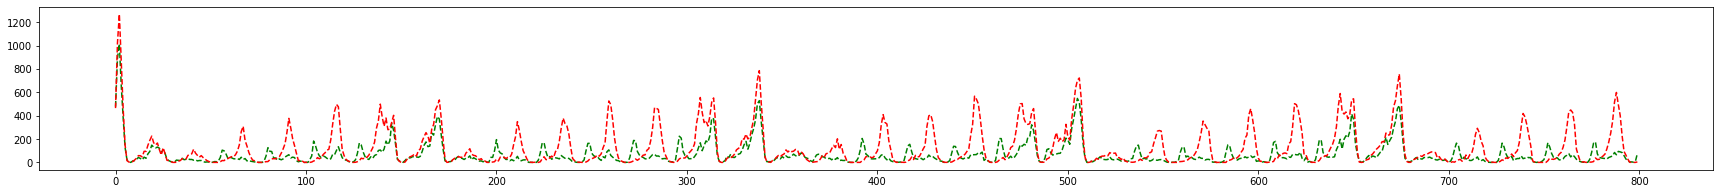


Region ID  62


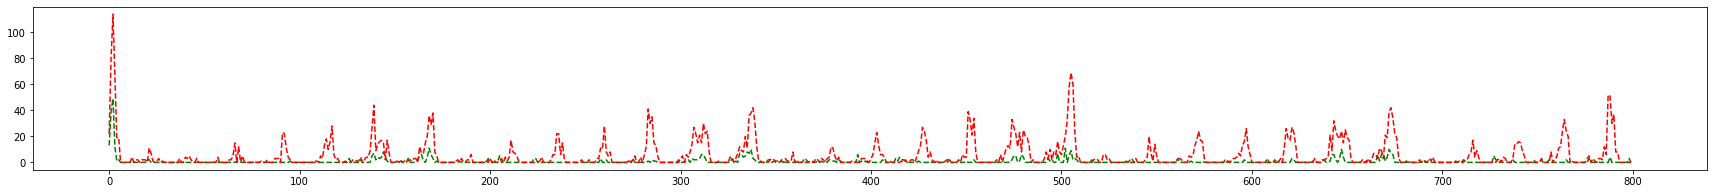


Region ID  66


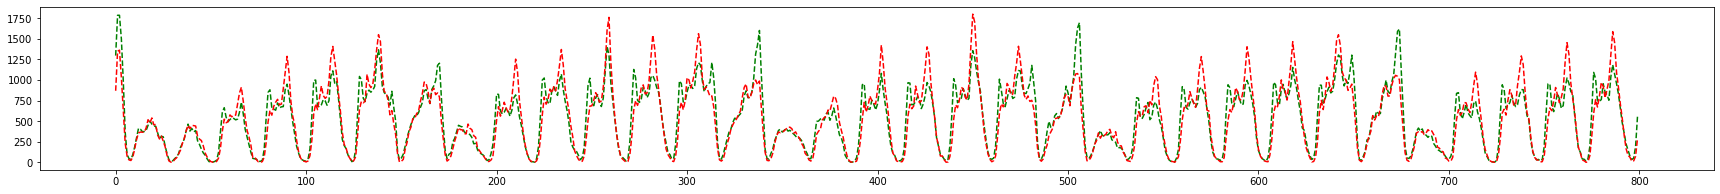


Region ID  82


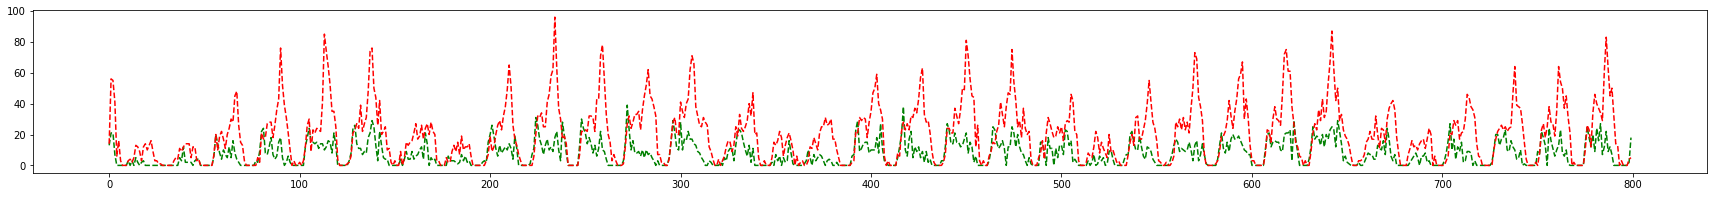


Region ID  26


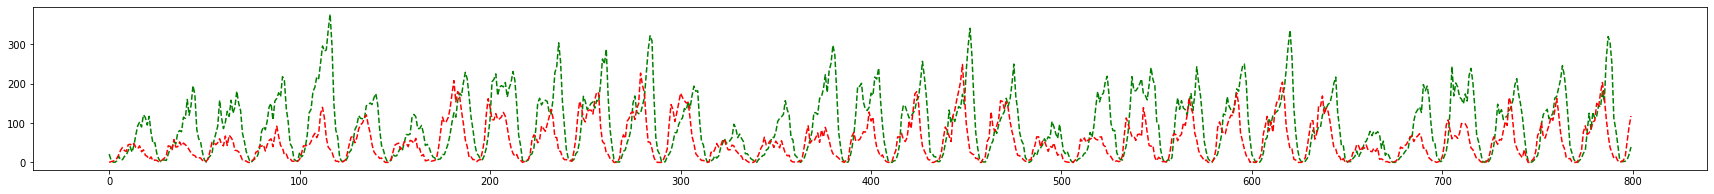


time: 905 ms


In [ ]:
regionsToPlotArray = [60, 62, 66, 82, 26]

for regionToPlot in regionsToPlotArray:
  plotTimeSeriesForOneRegion(regionToPlot, 800, 0)

In [ ]:
from scipy.stats import spearmanr
from matplotlib import pyplot

def plotTimeSeriesOneAgainstOne(timeSeries1, timeSeries2):
  pyplot.scatter(timeSeries1, timeSeries2)
  pyplot.show()

def returnCorrelationCoefficient(timeSeries1, timeSeries2):
  #returns coef, p 
  #Samples are correlated (reject H0) p> alpha, alpha = 0.05
  return spearmanr(timeSeries1, timeSeries2)

def returnIntersectionRegionIDsArrayAdjacentRegions(regionIDsArray, adjacentRegionIDsArray,regionIDsArrayStartIndex):
  intersectionRegionIDsArray = []
  reducedRegionIDsArray = regionIDsArray[regionIDsArrayStartIndex:]
  intersectionRegionIDsArray = [value for value in adjacentRegionIDsArray if value in reducedRegionIDsArray] 
  return intersectionRegionIDsArray

def returnCorrelationMatrixForTwoRegionIDs(regionID1, regionID2, regionIDsArray, correlationMatrix):
  regionIDIndex1 = regionIDsArray.index(regionID1)
  regionIDIndex2 = regionIDsArray.index(regionID2)
  return correlationMatrix[regionIDIndex1][regionIDIndex2]

def buildCorrelationMatrix(regionIDsArray, graphMatrix):
  correlationMatrix = np.identity(len(regionIDsArray))
  timeSeriesLastIndex = len(allRegionsTimeSeriesArray[0])
  timeSeriesStartIndex = 0
  n = len(regionIDsArray)
  i = 0
  while i < n:
    centralRegionID1 = regionIDsArray[i]
    newFlowTimeSeries1 = returnNewFlowTimeSeriesFor(centralRegionID1, timeSeriesLastIndex, timeSeriesStartIndex)
    endFlowTimeSeries1 = returnEndFlowTimeSeriesFor(centralRegionID1, timeSeriesLastIndex, timeSeriesStartIndex)
    newEndFlowTimeSeries1 = newFlowTimeSeries1 + endFlowTimeSeries1
    
    
    adjacentRegionIDsArray = returnConnectedRegionIDsFor(centralRegionID1, graphMatrix)
    intersectionRegionIDsArray = returnIntersectionRegionIDsArrayAdjacentRegions(regionIDsArray, adjacentRegionIDsArray,i)
    m = len(intersectionRegionIDsArray)
    j = 0
    while j < m: 
      adjacentRegionID = intersectionRegionIDsArray[j]
      newFlowTimeSeries2 = returnNewFlowTimeSeriesFor(adjacentRegionID, timeSeriesLastIndex, timeSeriesStartIndex)
      endFlowTimeSeries2 = returnEndFlowTimeSeriesFor(adjacentRegionID, timeSeriesLastIndex, timeSeriesStartIndex)
      newEndFlowTimeSeries2 = newFlowTimeSeries2 + endFlowTimeSeries2
      
      adjacentRegionID = returnIndexForRegionID(adjacentRegionID)
      correlation = returnCorrelationCoefficient(newEndFlowTimeSeries1, newEndFlowTimeSeries2)
      correlationMatrix[i][adjacentRegionID] = correlation[0]
      correlationMatrix[adjacentRegionID][i] = correlation[0]
      j = j + 1
    i = i + 1
  
  return correlationMatrix

time: 31.4 ms


In [ ]:
spearmanrCorrelationMatrix = buildCorrelationMatrix(allRegionsIDJanFebMar, graph_matrix)

time: 629 ms


In [ ]:
def returnHighestCorrelationsArray(regionIDsArray, correlationMatrix):
  n = len(correlationMatrix)
  m = len(correlationMatrix[0])
  i = 0
  min_threshold = 0.88
  highCorrelationArray = []
  while i < n:
    baseRegionID = regionIDsArray[i]
    j = i + 1
    while j < m:
      secondRegionID = regionIDsArray[j]
      if correlationMatrix[i][j] >= min_threshold:
        highCorrelationArray.append([baseRegionID,secondRegionID, correlationMatrix[i][j] ])
      j = j + 1
    i = i + 1
  
  return highCorrelationArray

def returnLowestCorrelationsArray(regionIDsArray, correlationMatrix):
  n = len(correlationMatrix)
  m = len(correlationMatrix[0])
  i = 0
  min_threshold = -0.08
  lowCorrelationArray = []
  while i < n:
    baseRegionID = regionIDsArray[i]
    j = i + 1
    while j < m:
      secondRegionID = regionIDsArray[j]
      if correlationMatrix[i][j] <= min_threshold:
        lowCorrelationArray.append([baseRegionID,secondRegionID, correlationMatrix[i][j] ])
      j = j + 1
    i = i + 1
  
  return lowCorrelationArray

time: 19.6 ms


In [ ]:
highCorrelationArray = returnHighestCorrelationsArray(allRegionsIDJanFebMar, spearmanrCorrelationMatrix)

print("High correlation matrix ", highCorrelationArray)

lowCorrelationArray = returnLowestCorrelationsArray(allRegionsIDJanFebMar, spearmanrCorrelationMatrix)

print("Low correlation matrix ", lowCorrelationArray)

High correlation matrix  [[72, 76, 0.9600738459972663], [72, 77, 0.8970808335460287], [76, 77, 0.9406674087419712], [76, 78, 0.8883407659955226]]
Low correlation matrix  [[85, 93, -0.09720961600771515]]
time: 5.48 ms


Region ID  72


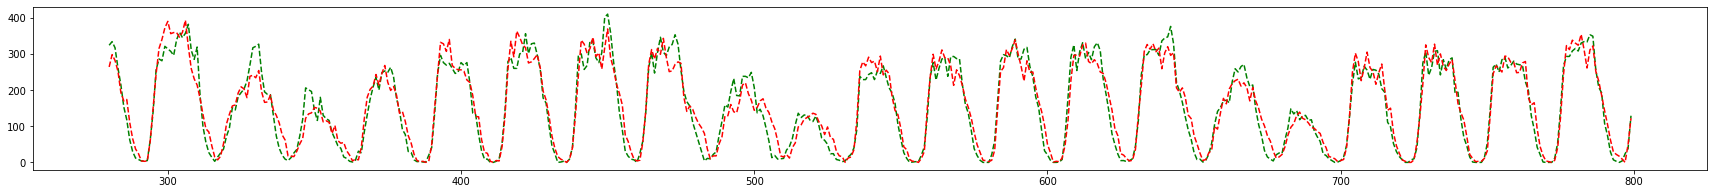


Region ID  76


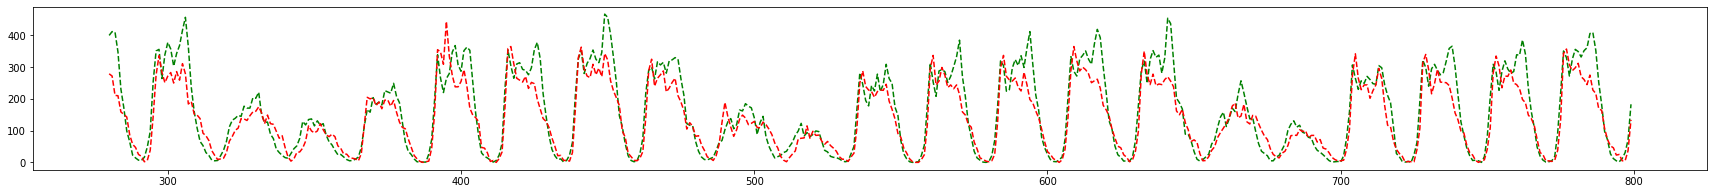


Region ID  77


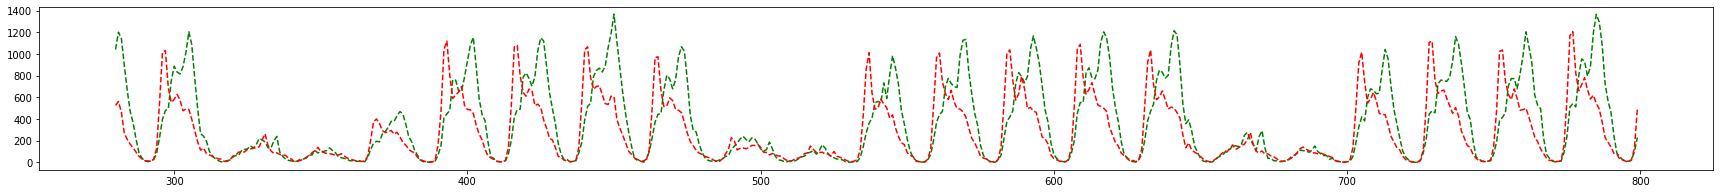


Region ID  78


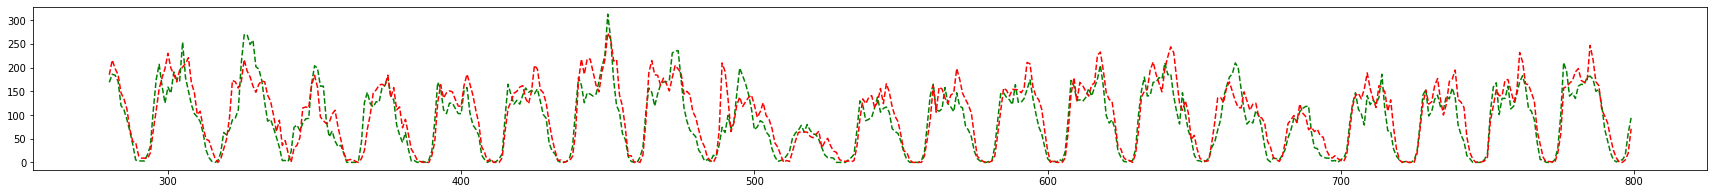


Region ID  85


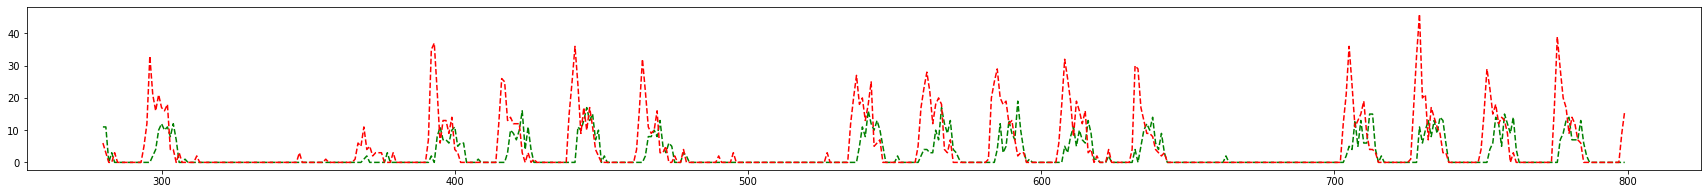


Region ID  93


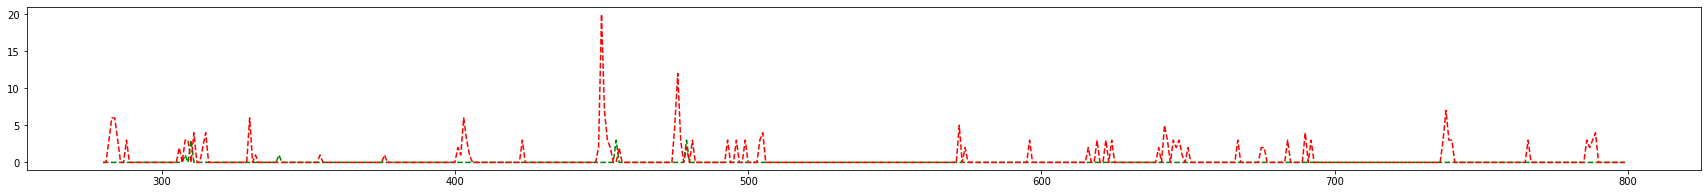


time: 1.08 s


In [ ]:
regionsToPlotArray = [72, 76, 77, 78, 85, 93]

for regionToPlot in regionsToPlotArray:
  plotTimeSeriesForOneRegion(regionToPlot, 800, 280)

In [ ]:
def returnTotalTaxiTripsNumberForPeriod(newEndFlowRegionIDtimeSeriesArray):
  totalTaxiTripsNumber = 0
  for taxiTripArray in newEndFlowRegionIDtimeSeriesArray:
    totalTaxiTripsNumber = totalTaxiTripsNumber + taxiTripArray[0] + taxiTripArray[1]
  
  return totalTaxiTripsNumber


def buildGraphNetworkArrayForMetisClustering(allRegionIDsArray, graphMatrix, correlationMatrix):
  n = len(allRegionIDsArray)
  i = 0
  graphNetworkForMetisClusteringArray = []
  edgeWeightForMetisClusteringArray = []
  nodeWeightForMetisClusteringArray = []
  
  newEndFlowtimeSeriesArray = []
  newEndFlowAllRegionIDstimeSeriesMatrix = rebuildMatrixForTImeSeries(data)

  while i < n - 1:
    regionID = allRegionIDsArray[i]
    adjacentRegionsArray = returnConnectedRegionIDsFor(regionID, graphMatrix)
    intersectionArray = returnIntersectionRegionIDsArrayAdjacentRegions(allRegionIDsArray, adjacentRegionsArray,i)
    for adjacentRegionId in intersectionArray:
      #edge 
      graphNetworkForMetisClusteringArray.append((regionID, adjacentRegionId))
      
      #edge weight equal to correlation between the regions
      edgeWeightValue = returnCorrelationMatrixForTwoRegionIDs(regionID, adjacentRegionId, allRegionIDsArray, correlationMatrix)
      edgeWeightForMetisClusteringArray.append(edgeWeightValue)

    #node weight as equal to all taxi trips for a region
    nodeWeightValue = returnTotalTaxiTripsNumberForPeriod(newEndFlowAllRegionIDstimeSeriesMatrix[i])
    nodeWeightForMetisClusteringArray.append(nodeWeightValue)
    i = i + 1

  return [graphNetworkForMetisClusteringArray, edgeWeightForMetisClusteringArray, nodeWeightForMetisClusteringArray]

time: 21.9 ms


In [ ]:
graphNetworkArrayForMetisClustering = buildGraphNetworkArrayForMetisClustering(allRegionsIDJanFebMar, graph_matrix, spearmanrCorrelationMatrix)

regionIDValue = 72
regionIDValue2 = 76 
regionIDValueIndex = allRegionsIDJanFebMar.index(regionIDValue)
regionIDValueIndex2 = allRegionsIDJanFebMar.index(regionIDValue2)

for index, edgePair in graphNetworkArrayForMetisClustering[0]:
  if edgePair[0] == regionIDValue and edgePair[1] == regionIDValue2:
    edgePairIndex = index 
    break

print("Correlation: ", spearmanrCorrelationMatrix[regionIDValueIndex][regionIDValueIndex2])

print("Edges network array", len(graphNetworkArrayForMetisClustering[0]))

print("Edge weights array: ", graphNetworkArrayForMetisClustering[1])

print("Nodes weights: ", graphNetworkArrayForMetisClustering[2][regionIDValueIndex])

Correlation:  0.9600738459972663
graph Network Array For Metis Clustering:  3
Edges network array 227
Edge weights array:  [0.00790238188905448, -0.004006886892853477, 0.03674782993107969, 0.014956924402689909, -0.017687474861381766, -0.0032689519981120583, 0.21761980900619668, -0.006900869985997174, 0.2246123487200499, 0.15654411187502298, 0.0217616274917882, 0.18466106219865638, 0.211826508918916, 0.22583294075167482, 0.27639783850162886, 0.23664096271685925, 0.11195516395924801, 0.08544550718662143, -0.0071717914395198834, 0.03485395044221079, 0.006714408571482334, 0.0279021413568417, 0.08380847801840068, 0.01701081780970719, 0.15952673515941868, -0.011595431351497492, 0.1391801368061995, 0.17639043343484928, 0.19689202382999807, 0.05248890977847723, 0.14956716618144375, 0.36754236296425974, 0.388228635935893, 0.40737510332686294, 0.2801512288517008, 0.033233613389781265, 0.2970947423095612, 0.3835129955512601, 0.37302546473760817, 0.05581281482949257, 0.1485239102375345, 0.38269774

In [ ]:
#We save the labels, centroids and graph matrices for next steps 
from numpy import asarray
from numpy import savetxt
# define data

graphNetworkForMetisClusteringArray = graphNetworkArrayForMetisClustering[0]
edgeWeightForMetisClusteringArray = graphNetworkArrayForMetisClustering[1]
nodeWeightForMetisClusteringArray = graphNetworkArrayForMetisClustering[2]

data = asarray( graphNetworkForMetisClusteringArray )
# save to csv file
savetxt('/content/graphNetworkForMetisClusteringArray.csv', data, delimiter=';')


data = asarray( edgeWeightForMetisClusteringArray )
# save to csv file
savetxt('/content/edgeWeightForMetisClusteringArray.csv', data, delimiter=';')


data = asarray( nodeWeightForMetisClusteringArray )
# save to csv file
savetxt('/content/nodeWeightForMetisClusteringArray.csv', data, delimiter=';')

time: 17.2 ms


In [ ]:
graphNetworkForMetisClusteringArray = buildGraphNetworkArrayForMetisClustering(allRegionsIDJanFebMar, graph_matrix)

print("Graph array for Metis Clustering: ", graphNetworkForMetisClusteringArray)

print("Number of edges: ", len(graphNetworkForMetisClusteringArray))

Graph array for Metis Clustering:  [(6, 17), (6, 23), (6, 46), (6, 49), (8, 17), (8, 22), (11, 12), (11, 22), (11, 38), (11, 39), (11, 41), (12, 13), (12, 32), (12, 39), (12, 44), (12, 45), (13, 32), (13, 45), (17, 23), (17, 38), (17, 49), (22, 38), (23, 46), (23, 49), (26, 31), (26, 59), (32, 44), (32, 45), (38, 39), (38, 41), (38, 49), (38, 54), (38, 61), (38, 62), (38, 63), (39, 41), (39, 44), (39, 53), (39, 54), (41, 54), (44, 45), (44, 53), (44, 54), (45, 50), (45, 53), (46, 49), (46, 59), (46, 64), (49, 59), (49, 61), (49, 64), (50, 53), (50, 60), (53, 54), (53, 60), (53, 62), (54, 60), (54, 62), (54, 63), (59, 64), (59, 70), (60, 62), (60, 65), (60, 66), (60, 67), (60, 68), (61, 62), (61, 63), (61, 64), (61, 65), (61, 68), (61, 69), (61, 70), (62, 63), (62, 65), (64, 69), (64, 70), (65, 67), (65, 68), (65, 69), (66, 67), (66, 72), (66, 75), (66, 76), (66, 77), (66, 82), (66, 83), (67, 68), (67, 75), (67, 80), (68, 69), (68, 80), (69, 70), (69, 80), (69, 86), (69, 89), (69, 91), 

In [ ]:
#Testing that code above works fine

print(allRegionsIDJanFebMar)

testRegionID = 6

testAdjacentRegionsArray = returnConnectedRegionIDsFor(testRegionID, graph_matrix)

print("connected regions ", testAdjacentRegionsArray )

intersectionArray = returnIntersectionRegionIDsArrayAdjacentRegions(allRegionsIDJanFebMar, testAdjacentRegionsArray,0)

print()

print("Intersection :", intersectionArray)


[6, 8, 11, 12, 13, 17, 22, 23, 26, 31, 32, 38, 39, 41, 44, 45, 46, 49, 50, 53, 54, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 76, 77, 78, 80, 82, 83, 85, 86, 87, 88, 89, 91, 93, 94, 95, 99, 100, 101, 103, 104, 108, 109, 110, 112, 113, 114, 115, 118, 120, 121, 123, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 141, 144, 145, 146, 147]
connected regions  [5, 7, 17, 23, 25, 30, 33, 34, 40, 46, 49]

Intersection : [17, 23, 46, 49]
time: 5.33 ms


In [ ]:
newEndFlowMatrix = []

nodeWeightsMatrix = [] #sum of new-flow and and flow for a region per unit of time
edgeWeightsMatrix = [] #similarity in crowd flows between regions

Show graphic results

Drawing lines and circles with varying radius: https://stackoverflow.com/questions/51434077/drawing-a-line-using-centroid-point-in-opencv

# **Sources**

1. To visualize the GPS coordinates on a real map: https://www.gps-coordinates.net/

2. To get the road network: https://overpass-turbo.eu/

3. Taxi trips data: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew